# Исследование объявлений о продаже квартир

Исследование рынка недвижимости Санкт-Петербурга и Ленинградской Области. 
  
Цель: определение рыночной стоимости объектов жилой недвижимости в регионе и ключевых факторов, влияющих на стоимость жилья.
  
Источник: архив сервиса Яндекс.Недвижимость за 2018 год.
  
Данные: указанные пользователем и полученные автоматические получены автоматически на основе картографических данных (расстояние до центра, аэропорта, ближайшего парка и водоёма)

## План выполнения проекта
1. Предобработка данных: 
  1. Изучение общей информации о данных и формирование промежуточных выводов о природе возникновения пропусков. 
  2. Выделение колонок, в которых обогащение данных необходимо
  3. Определение колонок, в которых необходимо изменение формата данных
2. Обогащение данных в первую очередь в определенных выше колонках, а также там, где это возможно
3. Исследование на предмет наличия выбросов во всех колонках с количественными данными
4. Приведение данных к единому перечню типов
5. Проведение дополнительных расчетов 
  1. цена квадратного метра
  2. день, месяц и год публикации объявления
  3. тип этажа (первый, последний, другой)
  4. отношение жилой площади к общей площади
  5. отношение площади кухни к общей площади
6. Ответы на поставленные в проекте вопросы

## Шаг 1. Откройте файл с данными и изучите общую информацию. 

### Общая информация о данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings


warnings.filterwarnings('ignore')

try:

    df_raw = pd.read_csv('C:/Users/urako/praktikum/DA/Projects/Course2_real_estate/real_estate_data.csv', sep='\t')

except:
    
    df_raw = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

df_raw_rows = df_raw.shape[0]
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Первые пять строк таблицы

In [2]:
df_raw.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

#### Пропуски:
1. _ceiling_height_: На основании количества пропусков (39% случаев), сложно однозначно указать на причину возникновения -   оно связано либо с тем, что пользователь не указал эти данные при публикации объявления, либо с системной ошибкой, либо по обеим причинам сразу;  
2. _floors_total_: возникновение вероятнее всего связано с пропусками при заполнении объявления (пропусков слишком мало для явной системной ошибки);  
3. _is_apartment_: наибольшее количество пропусков допущено именно в этой колонке. Вероятно, не все пользователи знают, что понимать под "апартаментами", и просто игнорируют это поле (возможно, стоит добавить пояснение в интерфейс формы для подачи объявлений);  
4. _kitchen_area_: возникновение вероятнее всего связано с пропусками при заполнении объявления (пропусков слишком мало для явной системной ошибки);  
5. _balcony_: пропуски могут означать отсутствие балконов в квартире; 
6. _locality_name_: согласно ТЗ, данная колонка заполняется автоматически. Вероятно, некорректно указанный адрес привел к сбою работы алгоритмов;
7. _airports_nearest_: вероятнее всего, пропуски допущены из-за слишком большого расстояния до аэропорта;
8. _cityCenters_nearest_: пропуски точно связаны со сбоем в алгоритмах (вероятнее всего система не знает, где у данного населенного пункта центр);
9. _parks_around3000_: вероятно, пропуск говорит об отсутствии парков в радиусе 3 км;
10. _parks_nearest_: вероятно, пропуск говорит об отсутствии парков в населенном пункте. Проверить можно следующим образом: если в качестве локации указан крупный населенный пункт, но в колонке при этом пропуск, значит, дело в системной ошибке 
11. _ponds_around3000_: пропуски могут говорить об отсутствии прудов в радиусе 3 км; 
12. _ponds_nearest_: вероятно, пропуск говорит об отсутствии прудов в населенном пункте. Проверить можно следующим образом: если в качестве локации указан крупный населенный пункт, но в колонке при этом пропуск, значит, дело в системной ошибке;  
13. _days_exposition_: вероятно, пропуски возникли в силу того, что публикация еще активна.  

####  Строго необходимые данные
Данные, непосредственно используемые при ответе на поставленные в ТЗ вопросы: пропуски в соответствующих колонках __обязательно должны быть устранены__
 1. last_price            23699 non-null  float64
 2. first_day_exposition  23699 non-null  object
 3. rooms                 23699 non-null  int64  
 4. ceiling_height        14504 non-null  float64
 5. floors_total          23613 non-null  float64
 6. living_area           21796 non-null  float64
 7. floor                 23699 non-null  int64  
 8. kitchen_area          21421 non-null  float64
 9. locality_name         23650 non-null  object
 10. days_exposition       20518 non-null  float64
  
  
#### Выбросы: 
  - На предмет наличия выбросов необходимо проверить все колонки с числовыми данными.  
  
#### Формат числовых значений: 
  - Необходимо привести все числовые значения к типу int64 (за редким исключением, об этом - ниже): это ускорит расчеты и упростит чтение таблицы.  
  - С той же целью имеет смысл перевести цены из рублей в тысячи рублей. Все объявления, в которых цена указана с точностью до сотен или десятков рублей, можно сохранить с округлением цены. 
  
#### Дубликаты
  - После заполнения пропусков необходимо выполнить поиск полных и скрытых дубликатов

## Шаг 2. Предобработка данных

### Обработка пропусков

#### Колонка _ceiling_height_

Обогащение данных на первом этапе проводится по следующему алгоритму:  
1. Данные в колонках, по которым группируются данные и вычисляются средние, проверяются на предмет наличия выбросов
1. Данные группируются по населенным пунктам и этажности домов
2. Для каждой группы вычисляются медианные значения высот потолков
3. Пропуски заполняются в соответствии с принадлежностью дома к определенной группе

Сводная информация о данных в столбце:

In [3]:
df_raw['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

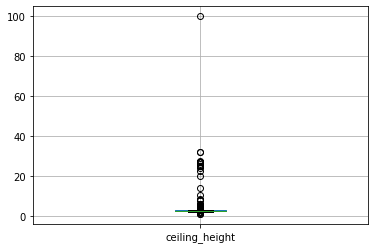

In [4]:
df_raw.boxplot(column='ceiling_height')
plt.show()

Согласно полученым сведениям, от нормы выбиваются и минимальные, и максимальные значения: в жилых домах потолки высотой в 100 метров не встречаются в принципе, а потолки высотой в метр запрещены законом.  
Согласно диаграмме размаха, аномально больших значений не так много.  
Оценим распределение величин свыше 4 метров

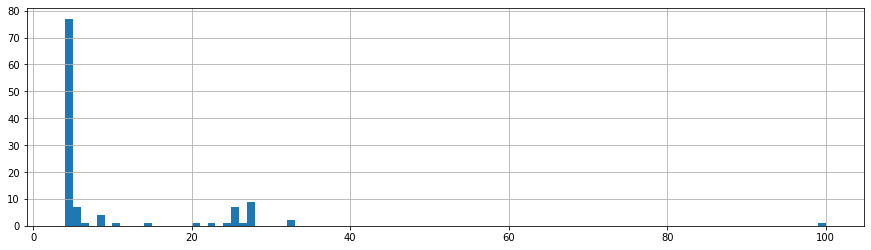

In [5]:
df_raw['ceiling_height'].hist(figsize=(15, 4), range=(4, 100), grid=True, bins=100-4)
plt.show()

In [6]:
more_than_six = df_raw.query('ceiling_height > 4')['ceiling_height'].count()
print(f'Количество объявлений о квартирах с высотой потолков свыше 4 метров: {more_than_six}')

Количество объявлений о квартирах с высотой потолков свыше 4 метров: 75


Количество подобных объявлений значительно меньше общего объема данных, значит, их можно удалить.  
Предел в 6 метров был выбран исходя из специфики петербуржской архитектуры, где на продажу могут выставлять жилые помещения в старых домах, знаменитых высокими потолками. 

In [7]:
df_raw = df_raw.drop(df_raw.loc[df_raw.loc[:, 'ceiling_height'] >= 4].index).reset_index(drop=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23585 entries, 0 to 23584
Data columns (total 22 columns):
total_images            23585 non-null int64
last_price              23585 non-null float64
total_area              23585 non-null float64
first_day_exposition    23585 non-null object
rooms                   23585 non-null int64
ceiling_height          14390 non-null float64
floors_total            23499 non-null float64
living_area             21690 non-null float64
floor                   23585 non-null int64
is_apartment            2747 non-null object
studio                  23585 non-null bool
open_plan               23585 non-null bool
kitchen_area            21322 non-null float64
balcony                 12126 non-null float64
locality_name           23537 non-null object
airports_nearest        18064 non-null float64
cityCenters_nearest     18084 non-null float64
parks_around3000        18085 non-null float64
parks_nearest           8016 non-null float64
ponds_around300

Распределение данных о высоте потолков после удаления выбросов "сверху": 

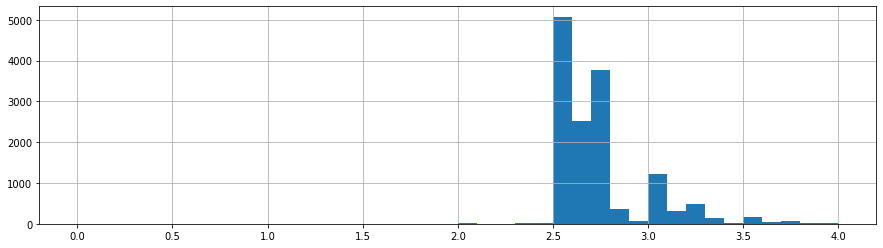

In [8]:
df_raw['ceiling_height'].hist(range=(0, 4), bins=40, figsize=(15, 4))
plt.show()

Видно, что абсолютное большинство объявлений содержат данные о высоте потолков в диапазоне от 2 до 3 метров.  
Перестроим диаграмму размаха: 

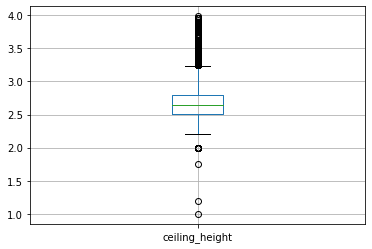

In [9]:
df_raw.boxplot(column='ceiling_height')
plt.show()

Видно, что присутствуют объявления о квартирах с высотой потолков ниже 2.5 метров. Оценим их количество. 

In [10]:
less_than_two = df_raw.query('ceiling_height < 2.5')['ceiling_height'].count()
print(f'Количество объявлений с высотой потолков ниже 2.5 метров: {less_than_two}')

Количество объявлений с высотой потолков ниже 2.5 метров: 73


Количество таких объявлений позволяет просто удалить их, признав выбросами. 

In [11]:
df_raw = df_raw.drop(df_raw.loc[df_raw.loc[:, 'ceiling_height'] < 2.5].index).reset_index(drop=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23512 entries, 0 to 23511
Data columns (total 22 columns):
total_images            23512 non-null int64
last_price              23512 non-null float64
total_area              23512 non-null float64
first_day_exposition    23512 non-null object
rooms                   23512 non-null int64
ceiling_height          14317 non-null float64
floors_total            23426 non-null float64
living_area             21623 non-null float64
floor                   23512 non-null int64
is_apartment            2735 non-null object
studio                  23512 non-null bool
open_plan               23512 non-null bool
kitchen_area            21256 non-null float64
balcony                 12083 non-null float64
locality_name           23464 non-null object
airports_nearest        18022 non-null float64
cityCenters_nearest     18042 non-null float64
parks_around3000        18043 non-null float64
parks_nearest           7990 non-null float64
ponds_around300

Оценим данные об этажности домов.

In [12]:
df_raw['floors_total'].describe()

count    23426.000000
mean        10.704132
std          6.598717
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

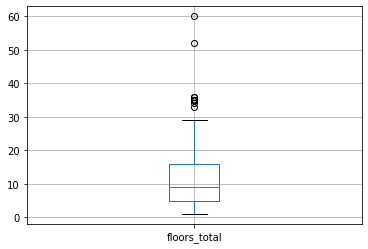

In [13]:
df_raw.boxplot('floors_total')
plt.show()

Проверим, где расположены дома выше 30 этажей. Если, они расположены не в крупных городах, признаем эти данные выбросами и удалим. 

In [14]:
hiegher_30_cicties = df_raw.loc[df_raw.loc[:, 'floors_total'] > 30]['locality_name'].unique()
print('Все дома в выборке выше 30 этажей расположены в городах', ', '.join(hiegher_30_cicties))

Все дома в выборке выше 30 этажей расположены в городах Санкт-Петербург, Кронштадт


И Санкт-Петербург, и Кронштадт можно признать крупными городами (население 5.400.000 и 44.461 человек на 2020 г. соответственно), в которых встречаются дома выше 30 этажей.  
Будем считать, что внесение данных о расположении продаваемого жилья вносятся таким образом, что один и тот же населенный пункт не может быть записан под разными именами, это позволяет нам перейти непосредственно к группировке.  
Как было сказано выше, на первом этапе заполнения данные группируются по населенным пунктам, затем по этажности домов. Пропуски заполняются медианными значениями для каждой из выделенных групп. 

In [15]:
def ceiling_height_fillna(df):
    """
    Функция заполняет пропуски в колонке "ceiling_height". 
    Объявления группируются по городам и этажности домов, для каждой группы вычисляется медианное значение, 
    которым и заполняются пропуски.
    Функция принимает на вход исследуемый датасет, возвращает кортеж из: датасета без пропусков, 
                                                                         количества пропусков до заполнения
                                                                         количества пропусков после заполнения
                                                                         процент, на который сократилось количество пропусков
    
    df: исследуемый датасет
    ceiling_height_na_before: количество пропусков в колонке "ceiling_height" до обогащения
    df_no_na: исходный датасет без пропусков
    df_grouped: датасет без пропусков, сгруппированный по городам и этажности
    df_filled_na: исходный датасет, в котором пропуски заполнены вычисленными медианными значениями
    ceiling_height_na_after: количество пропусков в колонке "ceiling_height" после обогащения
    ceiling_height_na_percentage: процент, на который сократилось количество пропусков в колонке "ceiling_height"
    """
    
    ceiling_height_na_before = df['ceiling_height'].isna().sum()
    df_no_na = df.drop(df.loc[df.loc[:, 'locality_name'].isna()].index)
    df_no_na = df_no_na.drop(df_no_na.loc[df_no_na.loc[:, 'floors_total'].isna()].index)
    df_grouped = (df_no_na.groupby(['locality_name', 'floors_total'])
                          .agg({'ceiling_height': 'median'})
                          .rename(columns={'ceiling_height': 'ceiling_height_median'}))
    df_filled_na = df.merge(df_grouped, on=['locality_name', 'floors_total'], how='left')
    df_filled_na.loc[df_filled_na.loc[:, 'ceiling_height'].isna(), 'ceiling_height'] = df_filled_na.loc[df_filled_na.loc[:, 'ceiling_height'].isna(), 'ceiling_height_median']
    ceiling_height_na_after = df_filled_na['ceiling_height'].isna().sum()
    ceiling_height_na_percentage = (ceiling_height_na_before - ceiling_height_na_after)/ceiling_height_na_before
    return df_filled_na, ceiling_height_na_before, ceiling_height_na_after, ceiling_height_na_percentage
    
    

ceiling_height_before_filling = df_raw['ceiling_height']
df_raw, ceiling_height_na_before, ceiling_height_na_after, ceiling_height_na_percentage = ceiling_height_fillna(df_raw)
print(f'Количество пропусков в колонке "ceiling_height" до заполнения: {ceiling_height_na_before}')
print(f'Количество пропусков в колонке "ceiling_height" после заполнения: {ceiling_height_na_after}')
print('Количество сократилось на {:.1%}'.format(ceiling_height_na_percentage))

Количество пропусков в колонке "ceiling_height" до заполнения: 9195
Количество пропусков в колонке "ceiling_height" после заполнения: 510
Количество сократилось на 94.5%


После первого этапа обогащения осталось 5.5% от изначального количества пропусков. Это связано с тем, что в исходной таблице в этих строчках данные были пропущены и в колонке _locality_name_, и в колонке _floors_total_ .  
Оставшиеся пропуски будут заполнены путем группировки только по этажности по аналогичному примененному выше принципу. 

In [16]:
def ceiling_height_fillna_rest(df):
    """
    Функция заполняет пропуски в колонке "ceiling_height", оставшиеся после первого этапа обогащения. 
    Объявления группируются по этажности домов, для каждой группы вычисляется медианное значение, 
    которым и заполняются пропуски.
    Функция принимает на вход исследуемый датасет, возвращает кортеж из: датасета без пропусков, 
                                                                         количества пропусков до заполнения
                                                                         количества пропусков после заполнения
                                                                         процент, на который сократилось количество пропусков
    
    df: исследуемый датасет
    ceiling_height_na_before: количество пропусков в колонке "ceiling_height" до обогащения
    df_no_na: исходный датасет без пропусков
    df_grouped: датасет без пропусков, сгруппированный по городам и этажности
    df_filled_na: исходный датасет, в котором пропуски заполнены вычисленными медианными значениями
    ceiling_height_na_after: количество пропусков в колонке "ceiling_height" после обогащения
    ceiling_height_na_percentage: процент, на который сократилось количество пропусков в колонке "ceiling_height"
    """
    
    ceiling_height_na_before = df['ceiling_height'].isna().sum()
    df_no_na = df.drop(df.loc[df.loc[:, 'locality_name'].isna()].index)
    df_no_na = df_no_na.drop(df_no_na.loc[df_no_na.loc[:, 'floors_total'].isna()].index)
    df_grouped = (df_no_na.groupby('floors_total')
                          .agg({'ceiling_height': 'median'})
                          .rename(columns={'ceiling_height': 'ceiling_height_median_floors'}))
    df_filled_na = df.merge(df_grouped, on=['floors_total'], how='left')
    df_filled_na.loc[df_filled_na.loc[:, 'ceiling_height'].isna(), 'ceiling_height'] = df_filled_na.loc[df_filled_na.loc[:, 'ceiling_height'].isna(), 'ceiling_height_median_floors']
    ceiling_height_na_after = df_filled_na['ceiling_height'].isna().sum()
    ceiling_height_na_percentage = (ceiling_height_na_before - ceiling_height_na_after)/ceiling_height_na_before
    return df_filled_na, ceiling_height_na_before, ceiling_height_na_after, ceiling_height_na_percentage
    
    
df_raw, ceiling_height_na_before, ceiling_height_na_after, ceiling_height_na_percentage = ceiling_height_fillna_rest(df_raw)
print(f'Количество пропусков в колонке "ceiling_height" до заполнения: {ceiling_height_na_before}')
print(f'Количество пропусков в колонке "ceiling_height" после заполнения: {ceiling_height_na_after}')
print('Количество сократилось на {:.1%}'.format(ceiling_height_na_percentage))

Количество пропусков в колонке "ceiling_height" до заполнения: 510
Количество пропусков в колонке "ceiling_height" после заполнения: 78
Количество сократилось на 84.7%


In [17]:
cities_with_no_ceiling = (', '.join(df_raw.loc[(df_raw.loc[:, 'ceiling_height'].isna())
                                             & ~(df_raw.loc[:, 'locality_name'].isna())]['locality_name'].unique()))
print(f'Населенные пункты, в которых остались объявления с пропусками в колонке "ceiling_height": {cities_with_no_ceiling}')

Населенные пункты, в которых остались объявления с пропусками в колонке "ceiling_height": Санкт-Петербург, Кудрово, посёлок Щеглово, посёлок Бугры, посёлок Мурино, городской посёлок Новоселье, Красное Село, поселок Мурино, поселок городского типа Токсово, деревня Новое Девяткино, посёлок Стрельна


Оставшиеся 78 пропусков могут быть удалены, так как присутствуют в объявлениях, поданых из мелких населенных пунктов, которые с низкой вероятностью попадут в выборку из 10 крупнейших источников объявлений, а численность объявлений из Санкт-Петербурга совершенно точно не сократилась бы значительным образом, даже если бы все 78 объявлений были поданы оттуда. 

In [18]:
df_raw = df_raw.drop(df_raw.loc[df_raw.loc[:, 'ceiling_height'].isna()].index).reset_index(drop=True)
ceiling_height_after_filling = df_raw['ceiling_height']
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23434 entries, 0 to 23433
Data columns (total 24 columns):
total_images                    23434 non-null int64
last_price                      23434 non-null float64
total_area                      23434 non-null float64
first_day_exposition            23434 non-null object
rooms                           23434 non-null int64
ceiling_height                  23434 non-null float64
floors_total                    23425 non-null float64
living_area                     21575 non-null float64
floor                           23434 non-null int64
is_apartment                    2734 non-null object
studio                          23434 non-null bool
open_plan                       23434 non-null bool
kitchen_area                    21221 non-null float64
balcony                         12037 non-null float64
locality_name                   23387 non-null object
airports_nearest                17953 non-null float64
cityCenters_nearest        

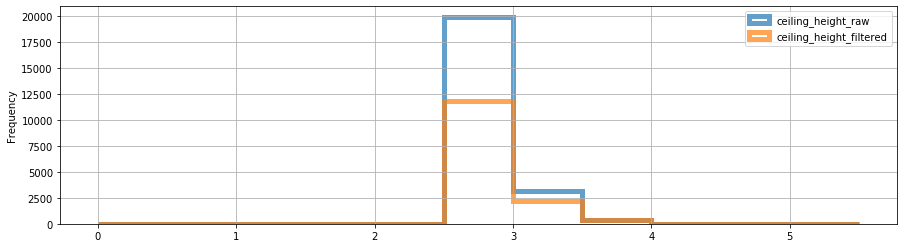

In [19]:
ax = ceiling_height_after_filling.plot(
    kind='hist',
    histtype='step',
    range=(0, 5.5),
    bins=11,
    linewidth=5,
    alpha=0.7,
    label='ceiling_height_raw',
    legend=True
)
ceiling_height_before_filling.plot(
    kind='hist',
    histtype='step',
    range=(0, 5.5),
    bins=11,
    linewidth=5,
    alpha=0.7,
    ax=ax,
    label='ceiling_height_filtered',
    grid=True,
    legend=True,
    figsize=(15, 4)
)
plt.show()

#### Колонка _floors_total_

Изучим строки с пропусками в колонке _floors_total_:

In [20]:
df_raw.loc[df_raw.loc[:, 'floors_total'].isna()].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_median,ceiling_height_median_floors
8375,19,13500000.0,77.8,2019-04-17T00:00:00,2,2.80,NaN,39.41,21,NaN,...,Санкт-Петербург,12838.0,11477.0,1.0,593.0,1.0,130.0,NaN,NaN,NaN
9942,9,3350000.0,25.0,2018-09-10T00:00:00,1,2.65,NaN,17.00,21,NaN,...,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,NaN
10443,12,14900000.0,100.0,2018-10-02T00:00:00,3,2.80,NaN,51.00,4,NaN,...,Санкт-Петербург,30766.0,8059.0,0.0,NaN,1.0,213.0,140.0,NaN,NaN
14095,13,14000000.0,94.0,2019-01-23T00:00:00,6,2.65,NaN,51.00,23,NaN,...,Санкт-Петербург,51333.0,13056.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
16475,0,15950000.0,108.0,2017-10-24T00:00:00,3,2.80,NaN,NaN,3,NaN,...,Санкт-Петербург,26402.0,5249.0,0.0,NaN,2.0,444.0,91.0,NaN,NaN
20023,5,6060000.0,60.6,2015-10-29T00:00:00,2,2.80,NaN,NaN,2,NaN,...,Санкт-Петербург,35231.0,13301.0,0.0,NaN,1.0,830.0,1257.0,NaN,NaN
21410,4,7143060.0,44.7,2019-01-11T00:00:00,1,3.00,NaN,13.79,19,NaN,...,Санкт-Петербург,9222.0,11340.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
22289,5,8500000.0,63.5,2017-05-24T00:00:00,2,2.80,NaN,NaN,3,NaN,...,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0,NaN,NaN
23393,6,3063600.0,43.8,2016-11-28T00:00:00,1,2.70,NaN,14.00,8,NaN,...,Санкт-Петербург,8426.0,12082.0,2.0,24.0,1.0,271.0,246.0,NaN,NaN


Во всей таблице пропуски в данной колонке присутствуют всего в 9 строках, 8 из которых - объявления поданые из Санкт-Петербурга. Более того, нет строк, в которых в поле _floor_ был бы указан первый этаж.  
Все пропуски будут удалены, так как статистические характеристики данных об объявлениях из Санкт-Петербурга совершенно точно не пострадают. 

In [21]:
df_raw = df_raw.drop(df_raw.loc[df_raw.loc[:, 'floors_total'].isna()].index).reset_index(drop=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23425 entries, 0 to 23424
Data columns (total 24 columns):
total_images                    23425 non-null int64
last_price                      23425 non-null float64
total_area                      23425 non-null float64
first_day_exposition            23425 non-null object
rooms                           23425 non-null int64
ceiling_height                  23425 non-null float64
floors_total                    23425 non-null float64
living_area                     21569 non-null float64
floor                           23425 non-null int64
is_apartment                    2734 non-null object
studio                          23425 non-null bool
open_plan                       23425 non-null bool
kitchen_area                    21216 non-null float64
balcony                         12035 non-null float64
locality_name                   23378 non-null object
airports_nearest                17945 non-null float64
cityCenters_nearest        

#### Колонка _living_area_.

In [22]:
living_area_na = df_raw.loc[df_raw.loc[:, 'living_area'].isna()]['total_images'].count()
living_area_na_percentage = living_area_na / df_raw.shape[0]
print(f'Количество строк с пропусками в колонке "living_area": {living_area_na}')
print('Процент пропусков в текущем объеме данных: {:.1%}'.format(living_area_na_percentage))

Количество строк с пропусками в колонке "living_area": 1856
Процент пропусков в текущем объеме данных: 7.9%


Процент достаточно высок, имеет смысл провести обогащение.  
Изучим первые пять строк таблицы и сводную информацию о таблице.

In [23]:
df_raw.loc[df_raw.loc[:, 'living_area'].isna()].head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_median,ceiling_height_median_floors
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.60,14.0,NaN,9,NaN,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2.60,2.60
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.75,24.0,NaN,22,NaN,...,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,2.75,2.75
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.55,9.0,NaN,2,NaN,...,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0,2.55,2.55
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,NaN,...,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0,2.50,2.57
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.76,22.0,NaN,3,NaN,...,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN,2.76,2.76


In [24]:
df_raw.loc[df_raw.loc[:, 'living_area'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1856 entries, 3 to 23423
Data columns (total 24 columns):
total_images                    1856 non-null int64
last_price                      1856 non-null float64
total_area                      1856 non-null float64
first_day_exposition            1856 non-null object
rooms                           1856 non-null int64
ceiling_height                  1856 non-null float64
floors_total                    1856 non-null float64
living_area                     0 non-null float64
floor                           1856 non-null int64
is_apartment                    118 non-null object
studio                          1856 non-null bool
open_plan                       1856 non-null bool
kitchen_area                    437 non-null float64
balcony                         476 non-null float64
locality_name                   1851 non-null object
airports_nearest                1244 non-null float64
cityCenters_nearest             1246 non-null flo

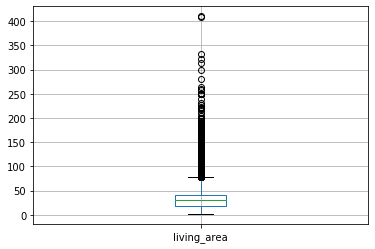

In [25]:
df_raw.boxplot('living_area')
plt.show()

Обнаружено большое количество объявлений с заявленой площадью выше 150 метров. Оценим количество подобных объявлений и взаимное распределение цен, и площадей. В случае, если будет обнаружено логичное соответствие "выше площадь - выше цена", до данные не будут признаны выбросами.  
Ниже - диаграмма рассеяния, где цена указана в сотнях миллионов рублей, площадь - в квадратных метрах. 

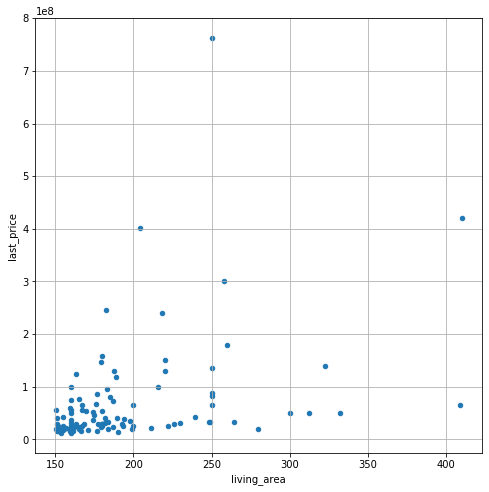

In [26]:
df_raw.query('living_area > 150').plot(x='living_area', y='last_price', kind='scatter', figsize=(8, 8), grid=True)
plt.show()

Распределение выглядит предсказуемо: абсолютное большинство точек - жилье площадью до 200 квадратных метров и стоимостью до 10 млн. рублей.  
Недвижимость экстримально большой площади не стоит выше 15 млн рублей. Скорее всего это - частные дома (если такие объявления присутствуют в выборке) или двухэтажные квартиры в старых домах.  
Однако, присутствует несколько точек, "стоимость" которых превышает 200 млн. рублей, а площадь не является экстримально высокой.  
Проанализируем этот срез. 

In [27]:
df_raw.query('last_price > 200000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_median,ceiling_height_median_floors
1415,19,330000000.0,190.0,2018-04-04T00:00:00,3,3.50,7.0,95.0,5,NaN,...,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0,3.000,3.000
5820,3,230000000.0,500.0,2017-05-31T00:00:00,6,3.00,7.0,NaN,7,NaN,...,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0,3.000,3.000
12811,19,763000000.0,400.0,2017-09-30T00:00:00,7,2.60,10.0,250.0,10,NaN,...,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0,2.600,2.600
13582,7,240000000.0,410.0,2017-04-01T00:00:00,6,3.40,7.0,218.0,7,NaN,...,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,199.0,3.000,3.000
14526,15,401300000.0,401.0,2016-02-20T00:00:00,5,2.55,9.0,204.0,9,False,...,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0,2.550,2.550
15462,20,300000000.0,618.0,2017-12-18T00:00:00,7,3.40,7.0,258.0,5,NaN,...,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0,3.000,3.000
16267,17,245000000.0,285.7,2017-04-10T00:00:00,6,3.35,7.0,182.8,4,NaN,...,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249.0,3.000,3.000
19313,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.80,25.0,409.7,25,NaN,...,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,2.750,2.750
22566,18,289238400.0,187.5,2019-03-19T00:00:00,2,3.37,6.0,63.7,6,NaN,...,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN,3.125,3.125


Все квартиры стоимостью выше 200 млн рублей расположены в Санкт-Петербурге. Причем практически всегда высокая стоимость соответствует сочетанию большой площади и близости к центру. Исключение - последняя строка среза. Высокая стоимость которой обусловлена исключительно близостью к центру.  
Данные не являются выбросами, можно приступать к обогащению. 

Обогащение будет проведено по следующему принципу: 
1. Данные группируются по городам, затем по этажности, затем по числу комнат
2. Для каждой группы вычисляются медианные значения жилой площади
3. Пропуски заполняются вычисленными медианными значениями (следует ожидать сохранения минимум 5-и пропусков в строчках, где присутствует пропуск данных о населенном пункте) 

In [28]:
living_area_before_filling = df_raw['living_area']

In [29]:
def living_area_fillna(df):
    """
    Функция заполняет пропуски в колонке "living_area". 
    Данные группируются по городам, этажности, количеству комнат; для каждой группы вычисляются медианные
    значения жилой площади, которыми и заполняются пропуски. 
    Функция принимает на вход исследуемый датасет, возвращает кортеж из: датасета без пропусков, 
                                                                         количества пропусков до заполнения
                                                                         количества пропусков после заполнения
                                                                         процент, на который сократилось количество пропусков
    
    df: обогащаемый датасет
    living_area_na_before: количество пропусков в колонке "living_area" до обогащения
    df_no_na: обогащаемый датасет без пропусков
    df_grouped: обогащаемый датасет, сгруппированный по населенным пунктам, этажности домов, количеству комнат, 
                в котором для каждой группы вычеслено медианное значение жилой площади
    df_filled_na: исследуемый датасет, в котором все пропуски заполнены полученными медианными значениями
    living_area_na_after: количество пропусков в колонке "living_area" после обогащения
    living_area_na_percentage: процент, на который сократилось количество пропусков
    """
    
    living_area_na_before = df['living_area'].isna().sum()
    df_no_na = df.drop(df.loc[df.loc[:, 'locality_name'].isna()].isna().index)
    df_no_na = df_no_na.drop(df_no_na.loc[df_no_na.loc[:, 'living_area'].isna()].isna().index)
    df_grouped = (df_no_na.groupby(['locality_name', 'floors_total', 'rooms'])
                          .agg({'living_area': 'median'})
                          .rename(columns={'living_area': 'living_area_median'}))
    df_filled_na = df.merge(df_grouped, how='left', on=['locality_name', 'floors_total', 'rooms'])
    df_filled_na.loc[df_filled_na.loc[:, 'living_area'].isna(), 'living_area'] = (
    df_filled_na.loc[df_filled_na.loc[:, 'living_area'].isna(), 'living_area_median'])
    living_area_na_after = df_filled_na['living_area'].isna().sum()
    living_area_na_percentage = (living_area_na_before - living_area_na_after) / living_area_na_before
    
    return df_filled_na, living_area_na_before, living_area_na_after, living_area_na_percentage


df_raw, living_area_na_before, living_area_na_after, living_area_na_percentage = living_area_fillna(df_raw)
print(f'Количество пропусков до заполнения: {living_area_na_before}')
print(f'Количество пропусков после заполнения: {living_area_na_after}')
print('Количество пропусков в колонке "living_area" сократилось на {:.1%}'.format(living_area_na_percentage))

Количество пропусков до заполнения: 1856
Количество пропусков после заполнения: 151
Количество пропусков в колонке "living_area" сократилось на 91.9%


Оставшиеся 152 пропуска - результат наличия в данных групп, у каждого члена которых пропущены данные о площади.  
Оставшиеся пропуски будут заполнены медианами для групп, составленых без учета местоположения:  
1. Данные группируются по этажности и количеству комнат
2. Пропуски заполняются медианными значениями для каждой из групп

In [30]:
def living_area_fillna_rest(df):
    """
    Функция заполняет оставшиеся пропуски в колонке "living_area". 
    Данные группируются только по этажности, количеству комнат; для каждой группы вычисляются медианные
    значения жилой площади, которыми и заполняются пропуски. 
    Функция принимает на вход исследуемый датасет, возвращает кортеж из: датасета без пропусков, 
                                                                         количества пропусков до заполнения
                                                                         количества пропусков после заполнения
                                                                         процент, на который сократилось количество пропусков
    
    df: обогащаемый датасет
    living_area_na_before: количество пропусков в колонке "living_area" до обогащения
    df_no_na: обогащаемый датасет без пропусков
    df_grouped: обогащаемый датасет, сгруппированный только по этажности домов, количеству комнат, 
                в котором для каждой группы вычеслено медианное значение жилой площади
    df_filled_na: исследуемый датасет, в котором все пропуски заполнены полученными медианными значениями
    living_area_na_after: количество пропусков в колонке "living_area" после обогащения
    living_area_na_percentage: процент, на который сократилось количество пропусков
    """
    
    living_area_na_before = df['living_area'].isna().sum()
    df_no_na = df.drop(df.loc[df.loc[:, 'locality_name'].isna()].isna().index)
    df_no_na = df_no_na.drop(df_no_na.loc[df_no_na.loc[:, 'living_area'].isna()].isna().index)
    df_grouped = (df_no_na.groupby(['floors_total', 'rooms'])
                          .agg({'living_area': 'median'})
                          .rename(columns={'living_area': 'living_area_median_no_city'}))
    df_filled_na = df.merge(df_grouped, how='left', on=['floors_total', 'rooms'])
    df_filled_na.loc[df_filled_na.loc[:, 'living_area'].isna(), 'living_area'] = (
    df_filled_na.loc[df_filled_na.loc[:, 'living_area'].isna(), 'living_area_median_no_city'])
    living_area_na_after = df_filled_na['living_area'].isna().sum()
    living_area_na_percentage = (living_area_na_before - living_area_na_after) / living_area_na_before
    
    return df_filled_na, living_area_na_before, living_area_na_after, living_area_na_percentage


df_raw, living_area_na_before, living_area_na_after, living_area_na_percentage = living_area_fillna_rest(df_raw)
print(f'Количество пропусков до заполнения: {living_area_na_before}')
print(f'Количество пропусков после заполнения: {living_area_na_after}')
print('Количество пропусков в колонке "living_area" сократилось на {:.1%}'.format(living_area_na_percentage))

Количество пропусков до заполнения: 151
Количество пропусков после заполнения: 3
Количество пропусков в колонке "living_area" сократилось на 98.0%


In [31]:
df_raw = df_raw.drop(df_raw.loc[df_raw.loc[:, 'living_area'].isna()].index).reset_index(drop=True)
living_area_after_filling = df_raw['living_area']
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 26 columns):
total_images                    23422 non-null int64
last_price                      23422 non-null float64
total_area                      23422 non-null float64
first_day_exposition            23422 non-null object
rooms                           23422 non-null int64
ceiling_height                  23422 non-null float64
floors_total                    23422 non-null float64
living_area                     23422 non-null float64
floor                           23422 non-null int64
is_apartment                    2734 non-null object
studio                          23422 non-null bool
open_plan                       23422 non-null bool
kitchen_area                    21216 non-null float64
balcony                         12034 non-null float64
locality_name                   23375 non-null object
airports_nearest                17943 non-null float64
cityCenters_nearest        

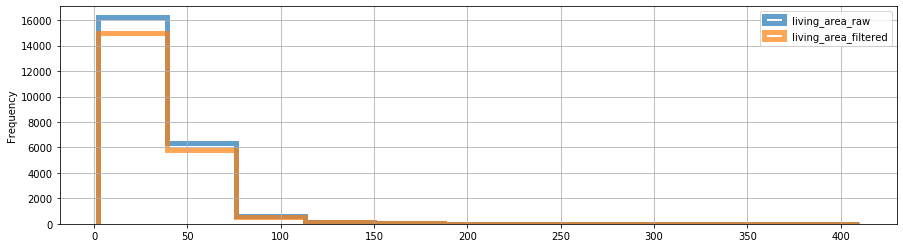

In [32]:
ax = living_area_after_filling.plot(
    kind='hist',
    histtype='step',
    bins=11,
    linewidth=5,
    alpha=0.7,
    label='living_area_raw',
    legend=True
)
living_area_before_filling.plot(
    kind='hist',
    histtype='step',
    bins=11,
    linewidth=5,
    alpha=0.7,
    ax=ax,
    label='living_area_filtered',
    grid=True,
    legend=True,
    figsize=(15, 4)
)
plt.show()

Гистограммы подобны друг другу, значит, обогащение не привело к значительному искажению распределения данных. 

#### Колонка _kitchen_area_.

Изучим распределение данных в колонке _kitchen_area_.

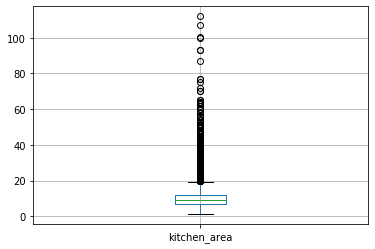

In [33]:
df_raw.boxplot('kitchen_area')
plt.show()

Большое количество данных выходит за верхний "ус".  
Изучим взаимное распределение данных о жилой площади и о площади кухни. 

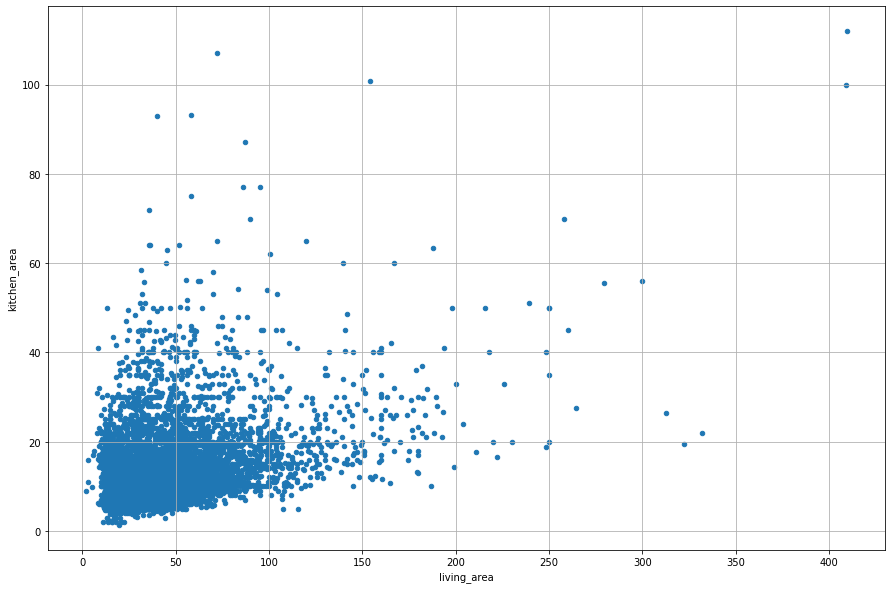

In [34]:
df_raw.plot(kind='scatter', x='living_area', y='kitchen_area', grid=True, figsize=(15, 10))
plt.show()

Из диаграммы рассеяния видно, что в абсолютном большинстве случаев площадь кухни меньше жилой, либо равна ей, однако, присутствуют объявления, в которых площадь кухни превышает жилую. Оценим объем этой выборки. 

In [35]:
df_raw.query('kitchen_area > living_area').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367 entries, 4 to 23299
Data columns (total 26 columns):
total_images                    367 non-null int64
last_price                      367 non-null float64
total_area                      367 non-null float64
first_day_exposition            367 non-null object
rooms                           367 non-null int64
ceiling_height                  367 non-null float64
floors_total                    367 non-null float64
living_area                     367 non-null float64
floor                           367 non-null int64
is_apartment                    32 non-null object
studio                          367 non-null bool
open_plan                       367 non-null bool
kitchen_area                    367 non-null float64
balcony                         179 non-null float64
locality_name                   366 non-null object
airports_nearest                296 non-null float64
cityCenters_nearest             296 non-null float64
parks_ar

Найдено 368 таких случаев.  
Не станем удалять эти данные, но будем иметь их в виду. 

Обогащение данных будет произведено по следующему принципу: 
1. Для каждого объявления будет определена группа, к которой он принадлежит исходя из своей площади
2. Объявления группируются по местоположению, затем по этажности, затем по группе площади
3. Для каждой группы вычисляются медианные значения площади кухни
4. На место пропусков помещаются вычисленные раньше медианные значения

In [36]:
def kitchen_area_fillna(df):
    """
    Функция заполняет пропуски в колонке "kitchen_area". 
    Для каждого объявления при помощи функции для строки определяется его "группа жилой площади". 
    Данные группируются по населенным пунктам, этажности домов, группам жилой площади. 
    Для полученных групп вычисляется медианные значения площади, которыми в дальнейшем заполняются пропуски. 
    Функция принимает на вход исследуемый датасет, возвращает кортеж из: датасета без пропусков, 
                                                                         количества пропусков до заполнения
                                                                         количества пропусков после заполнения
                                                                         процент, на который сократилось количество пропусков
    
    df: обогащаемый датасет
    kitchen_area_na_before: количество пропусков до обогащения
    df_no_na: датасет с удаленными пропусками в колонке "kitchen_area"
    df_grouped: датасет без пропусков, сгруппированный по населенным пунктам, этажности и группе жилой площади
    df_filled_na: обогащенный датасет
    kitchen_area_na_after: количество пропусков после обогащения
    kitchen_area_na_percentage: процент, на который сократилось количество пропусков
    """
    
    def living_area_group(row):
        """
        Функция присваивает строке датасета группу площади, исходя из данных, указанных в колонке "living_area". 
        Введено 15 групп площадей: менее 20, более 150, диапазон между этими отметками разбит на группы с шагом 
        в 10 метров (20 - 30 м, 30 - 40 м и т.д.)
        
        Функция принимает на вход ИСКЛЮЧИТЕЛЬНО ДАТАСЕТЫ БЕЗ ПРОПУСКОВ В КОЛОНКЕ "living_area", 
        возвращает строку с именем назначенной группы.
        """
        
        if row['living_area'] < 20:
            return 20
        elif 20 <= row['living_area'] < 30:
            return 30
        elif 30 <= row['living_area'] < 40:
            return 40
        elif 40 <= row['living_area'] < 50:
            return 50
        elif 50 <= row['living_area'] < 60:
            return 60
        elif 60 <= row['living_area'] < 70:
            return 70
        elif 70 <= row['living_area'] < 80:
            return 80
        elif 80 <= row['living_area'] < 90:
            return 90
        elif 90 <= row['living_area'] < 100:
            return 100
        elif 100 <= row['living_area'] < 110:
            return 110
        elif 110 <= row['living_area'] < 120:
            return 120
        elif 120 <= row['living_area'] < 130:
            return 130
        elif 130 <= row['living_area'] < 140:
            return 140
        elif 140 <= row['living_area'] < 150:
            return 150
        else: 
            return 'более 150'
        
    kitchen_area_na_before = df['kitchen_area'].isna().sum()
    df['living_area_group'] = df.apply(living_area_group, axis=1)
    df_no_na = df.drop(df.loc[df.loc[:, 'locality_name'].isna()].index)
    df_no_na = df_no_na.drop(df_no_na.loc[df_no_na.loc[:, 'kitchen_area'].isna()].index)
    df_grouped = df_no_na.groupby(['locality_name', 'floors_total', 'living_area_group']).agg({'kitchen_area': 'median'}).rename(columns={'kitchen_area': 'kitchen_area_median'})
    df_filled_na = df.merge(df_grouped, how='left', on=['locality_name', 'floors_total', 'living_area_group'])
    df_filled_na.loc[df_filled_na.loc[:, 'kitchen_area'].isna(), 'kitchen_area'] = (
    df_filled_na.loc[df_filled_na.loc[:, 'kitchen_area'].isna(), 'kitchen_area_median'])
    kitchen_area_na_after = df_filled_na['kitchen_area'].isna().sum()
    kitchen_area_na_percentage = (kitchen_area_na_before - kitchen_area_na_after) / kitchen_area_na_before
    
    return df_filled_na, kitchen_area_na_before, kitchen_area_na_after, kitchen_area_na_percentage


df_raw, kitchen_area_na_before, kitchen_area_na_after, kitchen_area_na_percentage = kitchen_area_fillna(df_raw)
print(f'Количество пропусков в колонке "kitchen_area" до обогащения: {kitchen_area_na_before}')
print(f'Количество пропусков в колонке "kitchen_area" после обогащения: {kitchen_area_na_after}')
print('Количество пропусков сократилось на {:.1%}'.format(kitchen_area_na_percentage))

Количество пропусков в колонке "kitchen_area" до обогащения: 2206
Количество пропусков в колонке "kitchen_area" после обогащения: 143
Количество пропусков сократилось на 93.5%


Осталось 143 строки с пропусками. Выведем поля, использовавшиеся для группировки для первых пяти таких случаев. 

In [37]:
df_raw.loc[df_raw.loc[:, 'kitchen_area'].isna(), ['locality_name', 'floors_total', 'living_area_group', 'kitchen_area_median']].head()

,locality_name,floors_total,living_area_group,kitchen_area_median
37,поселок городского типа Красный Бор,5.0,40,NaN
163,поселок городского типа Ефимовский,3.0,40,NaN
165,посёлок Плодовое,3.0,40,NaN
691,Пикалёво,9.0,50,NaN
903,деревня Кипень,3.0,30,NaN


Предположительно, эти пропуски не были заполнены, так как группа, для которой расчитывалась медиана, была представлена несколькими записями (или единственной записью), которые содержали пропуски.  
Проверим это утверждение: выведем все записи, совпадающие по параметрам группировки с 37 строкой. 

In [38]:
df_raw.query('locality_name == "поселок городского типа Красный Бор" and floors_total == 5 and living_area_group == "от 30 до 40"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_median,ceiling_height_median_floors,living_area_median,living_area_median_no_city,living_area_group,kitchen_area_median


Предположение подтвердилось.  
Оставшиеся 143 строки будут заполнены аналогичным образом, но группы будут сформированы без учета месторасположения недвижимости. 

In [39]:
def kitchen_area_fillna_rest(df):
    """
    Функция заполняет оставшиеся после первого этапа обогащения пропуски в колонке "kitchen_area".
    Данные группируются только по этажности домов и группам жилой площади. 
    Для полученных групп вычисляется медианные значения площади, которыми в дальнейшем заполняются пропуски. 
    Функция принимает на вход обогащаемый датасет, возвращает кортеж из: датасета без пропусков, 
                                                                         количества пропусков до заполнения
                                                                         количества пропусков после заполнения
                                                                         процент, на который сократилось количество пропусков
    
    df: обогащаемый датасет
    kitchen_area_na_before: количество пропусков до обогащения
    df_no_na: датасет с удаленными пропусками в колонке "kitchen_area"
    df_grouped: датасет без пропусков, сгруппированный по этажности и группе жилой площади
    df_filled_na: обогащенный датасет
    kitchen_area_na_after: количество пропусков после обогащения
    kitchen_area_na_percentage: процент, на который сократилось количество пропусков
    """
    
    kitchen_area_na_before = df['kitchen_area'].isna().sum()
    df_no_na = df.drop(df.loc[df.loc[:, 'locality_name'].isna()].index)
    df_no_na = df_no_na.drop(df_no_na.loc[df_no_na.loc[:, 'kitchen_area'].isna()].index)
    df_grouped = df_no_na.groupby(['floors_total', 'living_area_group']).agg({'kitchen_area': 'median'}).rename(columns={'kitchen_area': 'kitchen_area_median'})
    df_filled_na = df.merge(df_grouped, how='left', on=['floors_total', 'living_area_group'])
    df_filled_na.loc[df_filled_na.loc[:, 'kitchen_area'].isna(), 'kitchen_area'] = (
    df_filled_na.loc[df_filled_na.loc[:, 'kitchen_area'].isna(), 'kitchen_area_median'])
    kitchen_area_na_after = df_filled_na['kitchen_area'].isna().sum()
    kitchen_area_na_percentage = (kitchen_area_na_before - kitchen_area_na_after) / kitchen_area_na_before
    
    return df_filled_na, kitchen_area_na_before, kitchen_area_na_after, kitchen_area_na_percentage


df_raw.drop('kitchen_area_median', axis=1, inplace=True)
df_raw, kitchen_area_na_before, kitchen_area_na_after, kitchen_area_na_percentage = kitchen_area_fillna_rest(df_raw)
print(f'Количество пропусков в колонке "kitchen_area" до обогащения: {kitchen_area_na_before}')
print(f'Количество пропусков в колонке "kitchen_area" после обогащения: {kitchen_area_na_after}')
print('Количество пропусков сократилось на {:.1%}'.format(kitchen_area_na_percentage))

Количество пропусков в колонке "kitchen_area" до обогащения: 143
Количество пропусков в колонке "kitchen_area" после обогащения: 1
Количество пропусков сократилось на 99.3%


In [40]:
df_raw.loc[df_raw.loc[:, 'kitchen_area'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_median,ceiling_height_median_floors,living_area_median,living_area_median_no_city,living_area_group,kitchen_area_median
1674,11,3550000.0,28.0,2018-02-08T00:00:00,1,2.65,34.0,18.0,23,NaN,...,NaN,3.0,80.0,410.0,2.65,2.65,18.0,18.0,20,NaN


Оставшийся "уникальный" случай удаляется. 

In [41]:
df_raw = df_raw.drop(df_raw.loc[df_raw.loc[:, 'kitchen_area'].isna()].index).reset_index(drop=True)

После полного заполнения данных о площадях недвижимости, проведем фильтрацию, чтобы исключить возможные случаи, когда жилая площадь в сумме с площадью кухни превышает общую площадь.

In [42]:
df_raw = df_raw.query('kitchen_area + living_area < total_area')

#### Колонка _locality_name_. 

In [43]:
print('Количество объявлений без местоположения недвижимости: ', df_raw['locality_name'].isna().sum())

Количество объявлений без местоположения недвижимости:  45


Все пропуски в колонке _locality_name_ будут удалены. 

In [44]:
df_raw = df_raw.drop(df_raw.loc[df_raw.loc[:, 'locality_name'].isna()].index).reset_index(drop=True)

#### Колонка _days_exposition_. 

In [45]:
days_explosition_na = df_raw['days_exposition'].isna().sum()
total_rows_for_now = df_raw.shape[0]
print('Процент пропусков в колонке "days_exposition" на данный момент: {:.1%}'.format(days_explosition_na / total_rows_for_now))

Процент пропусков в колонке "days_exposition" на данный момент: 13.5%


Пропуски из этой колонки неозможно заполнить адекватными предположительными величинами, но и удалять их нецелесообразно в силу их относительно большого процента в выборке.  
Данные не будут изменяться; наличие пропусков будет учтено в дальнейшем. 

#### Колонка _balcony_.

Пропуски в колонке о количестве балконов будут заменены на нули из принципа: если количество балконов не было указано, значит, их нет. 

In [46]:
df_raw.fillna(value={'balcony': 0}, inplace=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22861 entries, 0 to 22860
Data columns (total 28 columns):
total_images                    22861 non-null int64
last_price                      22861 non-null float64
total_area                      22861 non-null float64
first_day_exposition            22861 non-null object
rooms                           22861 non-null int64
ceiling_height                  22861 non-null float64
floors_total                    22861 non-null float64
living_area                     22861 non-null float64
floor                           22861 non-null int64
is_apartment                    2660 non-null object
studio                          22861 non-null bool
open_plan                       22861 non-null bool
kitchen_area                    22861 non-null float64
balcony                         22861 non-null float64
locality_name                   22861 non-null object
airports_nearest                17588 non-null float64
cityCenters_nearest        

#### Колонка _is_apartment_.

Пропуски в этой колонке будут заполнены значениями False из принципа: если ничего не было указано, значит данная недвижимость не является апартаментами. 

In [47]:
df_raw.loc[df_raw.loc[:, 'is_apartment'].isna(), 'is_apartment'] = False
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22861 entries, 0 to 22860
Data columns (total 28 columns):
total_images                    22861 non-null int64
last_price                      22861 non-null float64
total_area                      22861 non-null float64
first_day_exposition            22861 non-null object
rooms                           22861 non-null int64
ceiling_height                  22861 non-null float64
floors_total                    22861 non-null float64
living_area                     22861 non-null float64
floor                           22861 non-null int64
is_apartment                    22861 non-null bool
studio                          22861 non-null bool
open_plan                       22861 non-null bool
kitchen_area                    22861 non-null float64
balcony                         22861 non-null float64
locality_name                   22861 non-null object
airports_nearest                17588 non-null float64
cityCenters_nearest         

#### Колонки с количественными автоматически-собранными данными

Обогащение данных в этих колонках невозможно в силу отсутствия признаков, которые бы явно определяли группы, на которые можно разбить данные для вычисления медианных или средних значений этих параметров. 
__Пропуски будут заполнены значениями -1__, это позволит легко получать срезы без пропусков, при этом позволит в любой момент отразить их количество.

In [48]:
df_raw.loc[df_raw.loc[:, 'airports_nearest'].isna(), 'airports_nearest'] = -1
df_raw.loc[df_raw.loc[:, 'cityCenters_nearest'].isna(), 'cityCenters_nearest'] = -1
df_raw.loc[df_raw.loc[:, 'parks_around3000'].isna(), 'parks_around3000'] = -1
df_raw.loc[df_raw.loc[:, 'parks_nearest'].isna(), 'parks_nearest'] = -1
df_raw.loc[df_raw.loc[:, 'ponds_around3000'].isna(), 'ponds_around3000'] = -1
df_raw.loc[df_raw.loc[:, 'ponds_nearest'].isna(), 'ponds_nearest'] = -1
df_raw.loc[df_raw.loc[:, 'days_exposition'].isna(), 'days_exposition'] = -1
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22861 entries, 0 to 22860
Data columns (total 28 columns):
total_images                    22861 non-null int64
last_price                      22861 non-null float64
total_area                      22861 non-null float64
first_day_exposition            22861 non-null object
rooms                           22861 non-null int64
ceiling_height                  22861 non-null float64
floors_total                    22861 non-null float64
living_area                     22861 non-null float64
floor                           22861 non-null int64
is_apartment                    22861 non-null bool
studio                          22861 non-null bool
open_plan                       22861 non-null bool
kitchen_area                    22861 non-null float64
balcony                         22861 non-null float64
locality_name                   22861 non-null object
airports_nearest                22861 non-null float64
cityCenters_nearest         

#### Промежуточный вывод

На данном этапе __пропуски были заполнены в колонках__: 
1. ceiling_height: в два этапа с группировкой по населенным пунктам и этажности
2. floors_total: в два этапа с группировкой по населенным пунктам, этажности и количеству комнат
3. living_area: в два этапа с группировкой по населенным пунктам, этажности и количеству комнат
4. kitchen_area: в два этапа с группировкой по населенным пунктам, этажности и присвоенной группе жилой площади
5. is_apartment: пропуски заполнены значениями _False_
6. balcony: пропуски были заполнены значениями _0_
7. Автоматически-собранные данные: все пропуски заполнены значениями _-1_

__Пропуски были удалены в колонках__ без попыток обогащения: 
1. locality_name

### Выбросы

На данном этапе на предмет наличия выбросов не были проверены колонки:
1. floor
2. total_area
3. last_price
4. balcony
5. rooms

#### Колонка _floor_

Колонка _floors_total_ уже была проверена на наличие выбросов.  
Выбросами в колонке _floor_ будут признаны случаи, когда этаж, на котором расположена квартира превышает максимальное количество этажей. 

In [49]:
floor_outlier = len(df_raw.loc[df_raw.loc[:, 'floors_total'] < df_raw.loc[:, 'floor']])
print(f'Количество выбросов в колонке "floor": {floor_outlier}')

Количество выбросов в колонке "floor": 0


#### Колонка _total_area_.

Построим график размаха для данных в колонке "total_area"

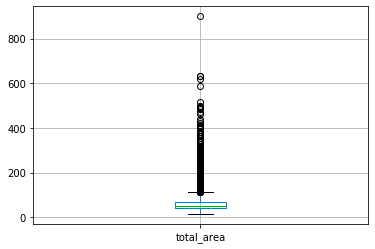

In [50]:
df_raw.boxplot('total_area')
plt.show()

Третья квартиль расположена в районе 150 метров, однако абсолютное большинство данных расположено в пределах 600 кв. метров.  
Все объявления, в которых указанная площадь превышает 600 метров будут удалены (граница взята "с запасом")

In [51]:
area_more_than_one_fifty = len(df_raw.query('total_area >= 150'))
print(f'Количество объявлений с заявленной площадью свыше 150 метров: {area_more_than_one_fifty}')
df_raw = df_raw.query('total_area < 150').reset_index(drop=True)

Количество объявлений с заявленной площадью свыше 150 метров: 551


#### Колонка _last_price_.
Ранее в пункте 1.3.1.3 были обнаружены единичные случаи превышения стоимости недвижимости отметки в 100 млн. руб.  
Оценим их точное количество

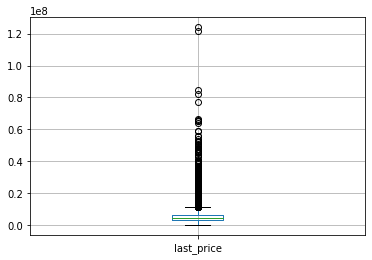

In [52]:
df_raw.boxplot('last_price')
plt.show()

In [53]:
# КОД РЕВЬЮВЕРА

df_raw.last_price.describe()

count    2.231000e+04
mean     5.711525e+06
std      4.498929e+06
min      1.219000e+04
25%      3.450000e+06
50%      4.600000e+06
75%      6.550000e+06
max      1.240000e+08
Name: last_price, dtype: float64

In [54]:
last_price_more_100 = df_raw.query('last_price > 100000000')['total_images'].count()
print(f'Количество объявлений с заявленой ценой свыше 100 млн. рублей: {last_price_more_100}')

Количество объявлений с заявленой ценой свыше 100 млн. рублей: 2


Учитывая тот факт, что большая часть выборки - бюджетный сегмент (об этом говорят статистические показатели выше), примем границы: "снизу" - 1 млн, "сверху" - 15 млн.  
Все объявления, выходящие за эти пределы признаны выбросами и удалены: 

In [55]:
deleted_rows_last_price = len(df_raw.query('last_price < 1000000 or last_price > 15000000'))
print(f'Количество объявлений с заявленой ценой менее 1 млн и более 15 млн: {deleted_rows_last_price}')
df_raw.drop(df_raw.loc[df_raw.loc[:, 'last_price'] > 15000000].index, inplace=True)
df_raw.drop(df_raw.loc[df_raw.loc[:, 'last_price'] < 1000000].index, inplace=True)

Количество объявлений с заявленой ценой менее 1 млн и более 15 млн: 902


#### Колонка _balcony_.
Построим график взаимного распределения данных о числе комнат и о числе балконов. 

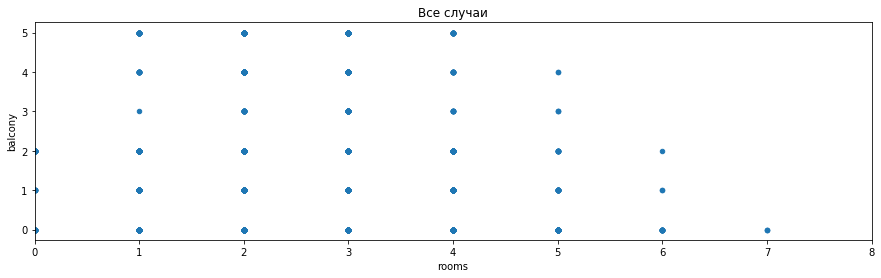

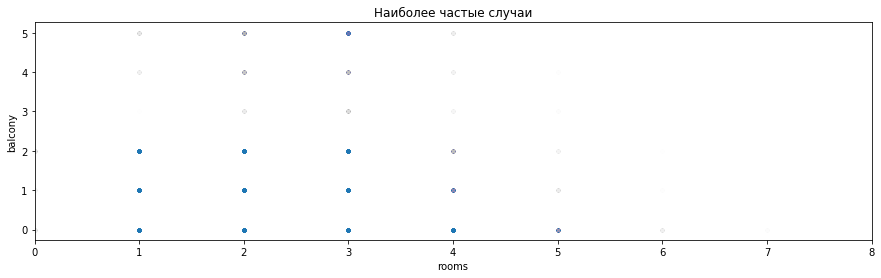

In [56]:
df_raw.plot(kind='scatter', y='balcony', x='rooms', xlim=(0, 8), figsize=(15, 4), title='Все случаи')
plt.show()
df_raw.plot(kind='scatter', y='balcony', x='rooms', xlim=(0, 8), figsize=(15, 4), alpha=0.005, title='Наиболее частые случаи')
plt.show()

Согласно взаимному распределению, число балконов не превышает 5, в абсолютном большинстве случаев число балконов либо равно числу комнат, либо превышает его на 1-2.  
Однако, присутствуют случаи, когда в однокомнатной квартире расположено 4 - 5 балконов. Оценим количество случаев, когда балконов больше, чем число комнат, включая кухню, более чем на 2. 

In [57]:
print('Число подобных случаев: ', len(df_raw.query('balcony - 1 - rooms > 2')))

Число подобных случаев:  24


Подобные значения редки и явно выбиваются из общей массы, потому их можно признать выбросами и удалить.

In [58]:
df_raw.drop(df_raw.loc[df_raw.loc[:, 'balcony'] - df_raw.loc[:, 'rooms'] - 1 > 2].index, inplace=True)

#### Колонка _rooms_.

Построим диаграмму размаха для данных в колонке с числом комнат.

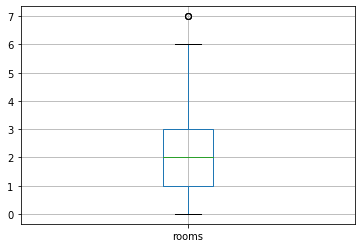

In [59]:
df_raw.boxplot('rooms')
plt.show()

Верхний ус расположен на отметке в 6 комнат. Оценим количество объявлений, расположеных выше этой отметки. 

In [60]:
print('Число объявлений с заявленым количеством комнат свыше 6: ', len(df_raw.query('rooms > 6')))

Число объявлений с заявленым количеством комнат свыше 6:  3


Подобных значений немного, потому признаем их выбросами и исключим из рассмотрения. 

In [61]:
df_raw.drop(df_raw.loc[df_raw.loc[:, 'rooms'] > 6].index, inplace=True)

#### Колонка _days_exposition_

In [62]:
df_raw['days_exposition'].describe()

count    21381.000000
mean       154.764323
std        210.462418
min         -1.000000
25%         23.000000
50%         73.000000
75%        196.000000
max       1580.000000
Name: days_exposition, dtype: float64

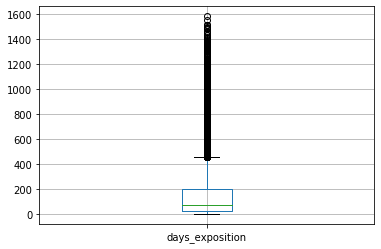

In [63]:
df_raw.boxplot('days_exposition')
plt.show()

Верхней границей назначена отметка в 600 дней на площадке.

In [64]:
more_than_six_hundred = len(df_raw.query('days_exposition > 600'))
print(f'Количество объявлений, продержавшихся на площадке свыше 600 дней: {more_than_six_hundred}')
df_raw.drop(df_raw.loc[df_raw.loc[:, 'days_exposition'] > 600].index, inplace=True)

Количество объявлений, продержавшихся на площадке свыше 600 дней: 1045


Все объявления, провисевшие на доске более 600 дней удалены.  
На этом этапе сокращение объема данных наибольшее. 

#### Промежуточный вывод: 
На этапе обработки выбросов были исследованы все запланированные колонки. Для каждой колонки были определены "правдоподобные" значения, все отличные от них значения были удалены.  
Оценим текущее сокращение объема данных: 

In [65]:
df_raw_rows_midterm = len(df_raw)
df_raw_rows_midterm_percentage = round(100 * (df_raw_rows - df_raw_rows_midterm) / df_raw_rows, 1)
print(f'Текущий объем данных: {df_raw_rows_midterm}')
print(f'На данном этапе сокращение объема составляет: {df_raw_rows_midterm_percentage}%')

Текущий объем данных: 20336
На данном этапе сокращение объема составляет: 14.2%


В результате обогащения данных и обработки выбросов объем сократился на 14.2%

In [66]:
# КОД РЕВЬЮВЕРА

# посмотрим на текущие статистики датафрейма

df_raw.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_median,ceiling_height_median_floors,living_area_median,living_area_median_no_city,kitchen_area_median
count,20336.000000,2.033600e+04,20336.000000,20336.000000,20336.000000,20336.000000,20336.000000,20336.000000,20336.000000,20336.000000,...,20336.000000,20336.000000,20336.000000,20336.000000,20336.000000,20014.000000,20336.000000,20233.000000,20336.000000,20336.000000
mean,9.869886,5.168052e+06,54.919041,1.976298,2.684473,10.807386,31.267849,5.902980,9.756267,0.597758,...,0.199695,157.504524,0.312844,195.376279,118.990313,2.665322,2.678383,31.290197,31.282083,9.115758
std,5.591195,2.609337e+06,20.065140,0.911543,0.195253,6.593082,14.029612,4.872768,3.995509,0.946612,...,0.945686,295.978671,1.072069,307.519202,134.811953,0.144405,0.149255,13.716418,13.626395,2.218714
min,0.000000,1.000000e+06,14.000000,0.000000,2.500000,1.000000,2.000000,1.000000,1.300000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.500000,2.550000,9.800000,10.500000,5.800000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,18.200000,2.000000,7.000000,0.000000,...,0.000000,-1.000000,0.000000,-1.000000,21.000000,2.550000,2.570000,18.000000,18.000000,7.000000
50%,10.000000,4.500000e+06,50.500000,2.000000,2.650000,9.000000,29.900000,4.000000,9.000000,0.000000,...,0.000000,-1.000000,0.000000,-1.000000,66.000000,2.600000,2.600000,30.000000,30.000000,9.000000
75%,14.000000,6.300000e+06,65.500000,3.000000,2.750000,16.000000,40.000000,8.000000,11.000000,1.000000,...,1.000000,273.000000,1.000000,379.250000,169.000000,2.700000,2.750000,42.300000,42.300000,10.370000
max,50.000000,1.500000e+07,149.000000,6.000000,3.980000,60.000000,117.100000,33.000000,64.000000,5.000000,...,3.000000,3190.000000,3.000000,1344.000000,600.000000,3.500000,3.125000,155.500000,155.500000,30.000000


### Формат числовых значений

1.  last_price - перевод в int64. Последнюю назначеную цену перед изменением типа данных выразим в тысячах рублей для удобства чтения
2.  first_day_exposition - перевод даты в читаемый вид в формате ГГГГ-ММ-ДД
3.  floors_total - переведем в формат int64
4.  balcony - переведем в формат int64
5.  days_exposition - переведем в формат int64 
6.  Все числовые геоданные также будут переведены в формат int64.

In [67]:
df_raw['last_price'] = df_raw['last_price'] / 1000
df_raw['last_price'] = df_raw['last_price'].astype('int64')
df_raw['first_day_exposition'] = pd.to_datetime(df_raw['first_day_exposition'], format='%Y-%m-%d')
df_raw['floors_total'] = df_raw['floors_total'].astype('int64')
df_raw['balcony'] = df_raw['balcony'].astype('int64')
df_raw['airports_nearest'] = df_raw['airports_nearest'].astype('int64')
df_raw['cityCenters_nearest'] = df_raw['cityCenters_nearest'].astype('int64')
df_raw['parks_around3000'] = df_raw['parks_around3000'].astype('int64')
df_raw['parks_nearest'] = df_raw['parks_nearest'].astype('int64')
df_raw['ponds_around3000'] = df_raw['ponds_around3000'].astype('int64')
df_raw['ponds_nearest'] = df_raw['ponds_nearest'].astype('int64')
df_raw['days_exposition'] = df_raw['days_exposition'].astype('int64')
df_raw['is_apartment'] = df_raw['is_apartment'].astype('bool')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20336 entries, 0 to 22309
Data columns (total 28 columns):
total_images                    20336 non-null int64
last_price                      20336 non-null int64
total_area                      20336 non-null float64
first_day_exposition            20336 non-null datetime64[ns]
rooms                           20336 non-null int64
ceiling_height                  20336 non-null float64
floors_total                    20336 non-null int64
living_area                     20336 non-null float64
floor                           20336 non-null int64
is_apartment                    20336 non-null bool
studio                          20336 non-null bool
open_plan                       20336 non-null bool
kitchen_area                    20336 non-null float64
balcony                         20336 non-null int64
locality_name                   20336 non-null object
airports_nearest                20336 non-null int64
cityCenters_nearest         

#### Промежуточный вывод
На этапе изменения типов данных большинство значений было приведено к целочисленному типу int64, что должно ускорить проведение расчетов и повысить их точность.  
Был введен тип данных datetime64[ns] для колонки "first_day_exposition". 

### Дубликаты

Примем, что в данных нет объявлений о продаже одних и тех же квартир, поданые с измененными ценами или указаными параметрами жилья.  
Будет проведена очистка только от полных дубликатов

In [68]:
rows_before_duplicate_drop = df_raw.shape[0]
df_raw = df_raw.drop_duplicates()
rows_after_duplicate_drop = df_raw.shape[0]
print('Количество строк после удаления дубликатов сократилось на {:.1%}'.format((rows_before_duplicate_drop - rows_after_duplicate_drop) / rows_before_duplicate_drop))

Количество строк после удаления дубликатов сократилось на 0.0%


#### Промежуточный вывод
Полных дубликатов в таблице не оказалось. 

### Выводы

In [69]:
df_clean = df_raw.drop(['ceiling_height_median', 'ceiling_height_median_floors', 
                        'living_area_median', 'living_area_median_no_city',
                        'kitchen_area_median'], axis=1)
df_clean_rows = df_clean.shape[0]
row_reduce_percentage = (df_raw_rows - df_clean_rows) / df_raw_rows
print('Общее сокращение объема данных составило {:.1%}'.format(row_reduce_percentage))

Общее сокращение объема данных составило 14.2%


На этапе предобработки данных: 
1. __Пропуски были устранены в полном объеме__, причем в случаях, когда обогащение было невозможно, __пропуски были заменены__ на значения _-1_ или подобные, что сохранило возможность получения информации о количестве пропусков.
2. Количественные значения были проверены на наличие __выбросов__ и выбивающихся значений, которые также были удалены
3. В некоторых колонках с числовыми значениями были __изменены типы данных__, также колонка с информацией о дате размещения была приведена к формату _datetime64[ns]_
4. Данные были исследованы на предмет наличия __дубликатов__. 
  
__Итоговое сокращение объема данных составило 14.2%__

## Шаг 3. Посчитайте и добавьте в таблицу

### Расчет стоимости квадратного метра

In [70]:
def square_meter_price(row):
    """
    Функция для строки
    Принимает на вход строку исследуемого датасета БЕЗ ПРОПУСКОВ в колонках "last_price" и "total_area". 
    
    row: строка исследуемого датасета
    return: округленное до целого значение цены квадратного метра в тысячах рублей
    """
    return round(row['last_price'] / row['total_area'])


df_clean['square_meter_price'] = df_clean.apply(square_meter_price, axis=1).astype('int')
df_clean.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_group,square_meter_price
0,20,13000,108.0,2019-03-07,3,2.700,16,51.0,8,False,...,Санкт-Петербург,18863,16028,1,482,2,755,-1,60,120
1,7,3350,40.4,2018-12-04,1,2.770,11,18.6,1,False,...,посёлок Шушары,12817,18603,0,-1,0,-1,81,20,83
2,10,5196,56.0,2015-08-20,2,2.600,5,34.3,4,False,...,Санкт-Петербург,21741,13933,1,90,2,574,558,40,93
3,2,10000,100.0,2018-06-19,2,3.030,14,32.0,13,False,...,Санкт-Петербург,31856,8098,2,112,1,48,121,40,100
4,10,2890,30.4,2018-09-10,1,2.625,12,14.4,5,False,...,городской посёлок Янино-1,-1,-1,-1,-1,-1,-1,55,20,95


### Определение дня недели, месяца и года публикации

Помимо определения номеров дня недели и месяца, в датасет также добавляется колонка с названиями дней и месяцев для удобства чтения

In [71]:
df_clean['year'] = df_clean['first_day_exposition'].dt.year
df_clean['month'] = df_clean['first_day_exposition'].dt.month
df_clean['month_name'] = df_clean['first_day_exposition'].dt.month_name
df_clean['day_of_the_week'] = df_clean['first_day_exposition'].dt.weekday
df_clean['day_of_the_week_name'] = df_clean['first_day_exposition'].dt.day_name

### Определение типа этажа

Выделены три типа этажей: "первый", "последний", "другой".  
Непосредственно исследоваться в дальнейшем будут значения "первый" и "последний"

In [72]:
df_clean.loc[df_clean.loc[:, 'floor'] == 1, 'floor_type'] = 'первый'
df_clean.loc[df_clean.loc[:, 'floor'] == df_clean.loc[:, 'floors_total'], 'floor_type'] = 'последний'
df_clean.loc[(df_clean.loc[:, 'floor'] != df_clean.loc[:, 'floors_total'])
           & (df_clean.loc[:, 'floor'] != 1), 'floor_type'] = 'другой'

### Определение отношений площадей

Расчитываются отношения жилой площади к общей, площади кухни к общей площади.  
Отношения будут занесены в таблицу с точностью до третьего знака после запятой

In [73]:
df_clean['living/total ratio'] = round(df_clean['living_area'] / df_clean['total_area'], 3)
df_clean['kitchen/total ratio'] = round(df_clean['kitchen_area'] / df_clean['total_area'], 3)
df_clean.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,living_area_group,square_meter_price,year,month,month_name,day_of_the_week,day_of_the_week_name,floor_type,living/total ratio,kitchen/total ratio
0,20,13000,108.0,2019-03-07,3,2.700,16,51.0,8,False,...,60,120,2019,3,<bound method PandasDelegate._add_delegate_acc...,3,<bound method PandasDelegate._add_delegate_acc...,другой,0.472,0.231
1,7,3350,40.4,2018-12-04,1,2.770,11,18.6,1,False,...,20,83,2018,12,<bound method PandasDelegate._add_delegate_acc...,1,<bound method PandasDelegate._add_delegate_acc...,первый,0.460,0.272
2,10,5196,56.0,2015-08-20,2,2.600,5,34.3,4,False,...,40,93,2015,8,<bound method PandasDelegate._add_delegate_acc...,3,<bound method PandasDelegate._add_delegate_acc...,другой,0.612,0.148
3,2,10000,100.0,2018-06-19,2,3.030,14,32.0,13,False,...,40,100,2018,6,<bound method PandasDelegate._add_delegate_acc...,1,<bound method PandasDelegate._add_delegate_acc...,другой,0.320,0.410
4,10,2890,30.4,2018-09-10,1,2.625,12,14.4,5,False,...,20,95,2018,9,<bound method PandasDelegate._add_delegate_acc...,0,<bound method PandasDelegate._add_delegate_acc...,другой,0.474,0.299


## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции

Необходимо исследовать распределение данных об общей площади, цене, количеству комнат и высоте потолков, указанных датасете.
  

Выделим исследуемые колонки в отдельные переменные.

In [74]:
area = df_clean['total_area']
last_price = df_clean['last_price']
rooms = df_clean['rooms']
ceiling_height = df_clean['ceiling_height']

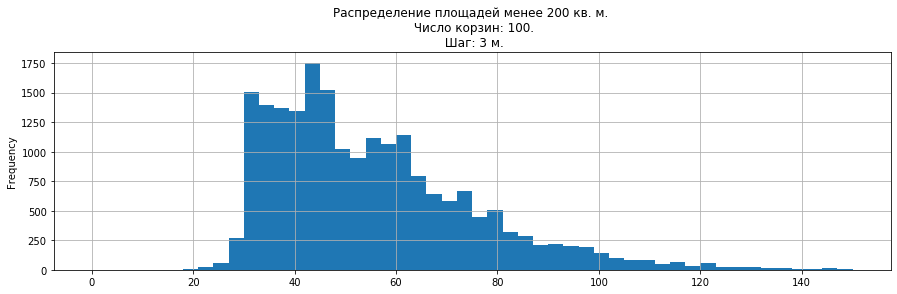

In [75]:
area.plot(kind='hist', range=(0, 150),
          bins=50, figsize=(15, 4), grid=True,
          title='Распределение площадей менее 200 кв. м. \n Число корзин: 100.\n Шаг: 3 м.')
plt.show()

Распределение выглядят закономерно:  
1. Абсолютное большинство недвижимости имеет общую площадь от 30 до 75 кв. м.
2. Количество объявлений с площадью свыше 80 кв. м. монотонно убывает на всей протяженности "хвоста" распределения

Построим распределения цены, указанной в объявлениях

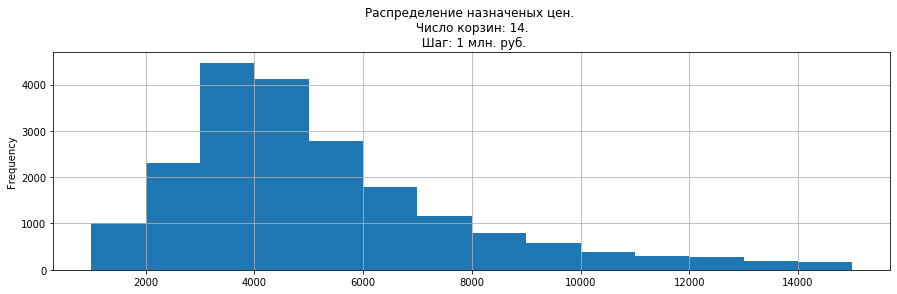

In [76]:
last_price.plot(kind='hist', 
                bins=14, figsize=(15, 4), grid=True,
                title='Распределение назначеных цен. \n Число корзин: 14. \n Шаг: 1 млн. руб.')
plt.show()

Из полученных распределений следует: 
1. Абсолютное большинство объявлений "продают" квартиры стоимостью от 2 до 6 млн. руб.
2. На всей протяженности графика, начиная с пика частоты на 4 млн. руб, количество объявлений монотонно убывают с ростом "стоимости" объявлений. 
3. При выбранном количестве корзин распределение принимает классическую форму распределения Пуассона

Построим распределение числа комнат по частоте встречаемости

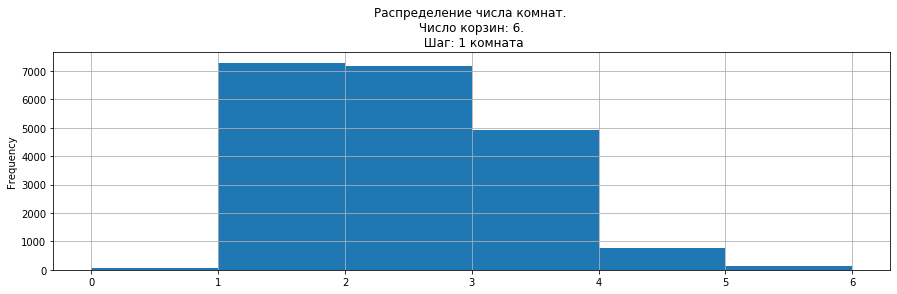

In [77]:
rooms.plot(kind='hist', range=(0, max(rooms)), 
          bins=6, figsize=(15, 4), grid=True, 
          title='Распределение числа комнат. \n Число корзин: 6. \n Шаг: 1 комната')
plt.show()

Из полученной гистограммы следует: 
1. Чаще всего встречаются квартиры с числом комнат от 1 до 4
2. Реже всего - квартиры студии
3. Промежуточное положение занимает недвижимость с числом комнат от 5 до 6

Построим распределение объявлений по высоте потолков.

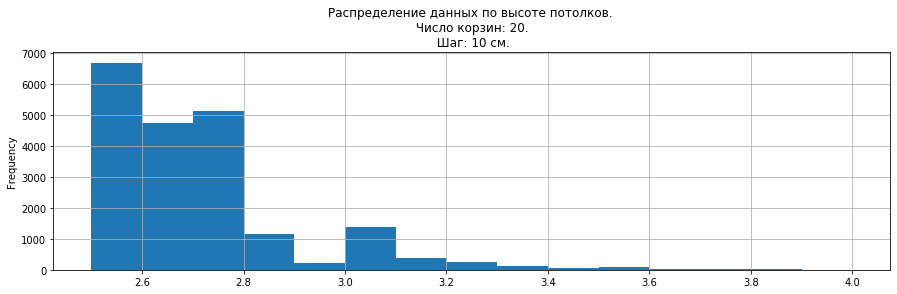

In [78]:
ceiling_height.plot(kind='hist', range=(2.5, 4),
                   bins = 15, figsize=(15, 4), grid=True, 
                   title='Распределение данных по высоте потолков. \n Число корзин: 20. \n Шаг: 10 см.')
plt.show()

Согласно полученному распределению, наиболее часто встречаемый случай высоты потолков - 2.5 - 2.8 метров.  
Интересно наличие резкого спада частоты после отметки в 2.8 метра. 

#### Зависимость цены за квадрат от жилой площади и площади кухни

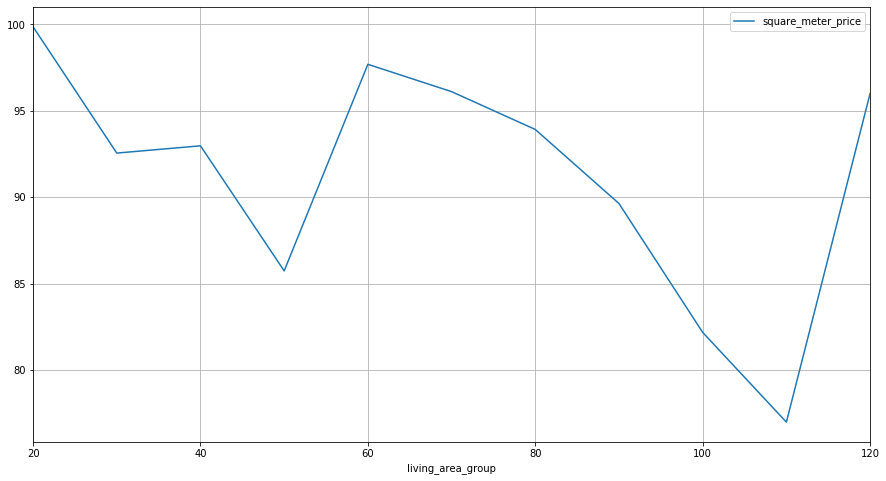

In [79]:
(df_clean.pivot_table(index='living_area_group', values='square_meter_price', aggfunc='mean')
         .sort_values(by='living_area_group', ascending=True)
         .plot(figsize=(15, 8), grid=True))
plt.show()

В представленном наборе данных между величинами жилой площади и ценой квадратного метра отсутствует какая-либо конкретная взаимосвязь: с ростом жилой площади средняя цена квадратного метра меняется скачкообразно.  
Примечательно лишь, что варианты с жилой площадью 50-60 кв.м. по стоимости квадратного метра значительно превышают варианты с жилой площадью 100-110 кв.м. Помимо этого, при увеличении площади до отметки в 110-120 кв.м. цена квадратного метра вновь взлетает. 

Перед построением аналогичного графика для площади кухни и цены квадратного метра, разобъем данные по группам площади кухни.  
Изучим распределение данных по площадям кухни:

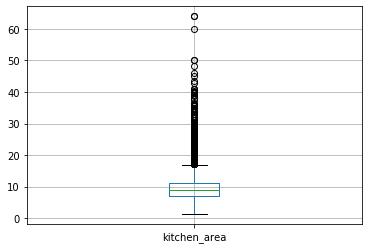

In [80]:
df_clean.boxplot('kitchen_area')
plt.show()

Разделим данные на 6 групп: 0-4, 5-8, 9-12, 13-16, 17-20, более 20 кв.м.

In [ ]:
def kitchen_area_group(row):
    lst = [4, 8, 12, 16, 20, 60]
    for element in lst:
        if row['kitchen_area'] < element:
            return element
        else:
            pass
    
    
df_clean['kitchen_area_group'] = df_clean.apply(kitchen_area_group, axis=1)
(df_clean.pivot_table(index='kitchen_area_group', values='square_meter_price', aggfunc='mean')
         .sort_values(by='kitchen_area_group')
         .plot(figsize=(15, 8), grid=True, title='Зависимость цены квадратного метра от площади кухни.\n В точке х=60 - все значения свыше 20 кв.м.'))
plt.show()

В зависимости цены квадратного метра от площади кухни присутствует заметная закономерность: начиная со значения площади кухни в 5-8 кв.м. цена кватратного метра монотонно возрастает.

#### Вывод
Согласно полученным распределеням можно сделать выводы о наиболее типичном наборе параметров недвижимости для данной выброки: 
1. Число комнат от 1 до 3
1. Площадь от 30 до 75 кв. м.
2. Высота потолков от 2.5 до 2.8 метров
3. Стоимость от 2 до 6 млн. руб.

### Время продажи квартиры

На этапе обогащения данных пропуски в колонке _days_exposition_ были заполнены значениями -1. На этапе анализа работа будет вестись со срезом:

Будет введена колонка _months_exposition_, отражающая время продажи в месяцах для больше наглядности:

In [ ]:
df_clean_time['months_exposition'] = df_clean_time['days_exposition'] / 30
df_clean_time['days_exposition'].plot(kind='hist', figsize=(15, 4), 
                                      grid=True, bins=16,
                                      title='Распределение продолжидельности продажи в днях. \n Количество корзин: 16 \n Шаг: 100 дней')
plt.show()

In [ ]:
df_clean_time['months_exposition'].plot(kind='hist', figsize=(15, 4), 
                                 grid=True, bins=20,
                                 title='Распределение продолжидельности продажи в месяцах. \n Количество корзин: 53 \n Шаг: 1 месяц')
plt.show()

Полученные распределения явно совпадают с распределением Пуассона.  
Изучим подробнее влияние назначенной цены на время продажи.  
Построим график взаимного распределения величин _last_price_ и _months_exposition_

In [ ]:
df_clean_time.plot(kind='scatter', y='last_price', x='months_exposition', 
                   figsize=(15, 15), grid=True, alpha=0.07)
plt.show()

На промежутке от 1 до 5 месяцев заметны "сгустки данных", изучим эту область подробнее. 

In [ ]:
df_clean_time.plot(kind='scatter', y='last_price', x='days_exposition', 
                   figsize=(15, 6), grid=True, alpha=0.07, xlim=(40,100), ylim=(0, 30000))
plt.show()

Действительно, существуют явные скопления объявлений, закрытых за 45, 60 и 90 дней. Оценим их объем и сравним, насколько количество закрытых объявлений за эти дни превышает аналогичный показатель за 44, 59 и 89 дни и за 46, 61 и 91 дни: 

In [ ]:
a = df_clean_time.query('days_exposition in (45, 60, 90)')['total_images'].count()
b = df_clean_time.query('days_exposition in (44, 59, 89)')['total_images'].count()
c = df_clean_time.query('days_exposition in (46, 61, 91)')['total_images'].count()
print(f'45/60/90 дней: {a}')
print(f'44/59/89 дней: {b}')
print(f'46/61/91 день: {c}')
print('Отношение 45/60/90 к 44/59/89: {:.1f}'.format(a / b))
print('Отношение 45/60 к 46/61/91: {:.1f}'.format(a / c))

Наличие артефакта очевидно: за 45, 60 и 90-е дни количество закрытых объявлений превышает аналогичный показатель "соседей снизу" и "сверху" в 4.8 и 6 раз соответственно.  
__Возникновение данного артефакта__ связаны с работой сервиса Яндекс.Недвижимость. Снятие этих объявлений не связано с какой-либо незаконной деятельностью или системными сбоями: данные будут оставлены в выборке

После обнаружения и исключения из рассмотрения упомянутого артефакта характер взаимного распределения изменился слабо.  
С уверенностью можно сказать, что назначенная цена не имеет ожидаемого сильного влияния на время продажи: в выборке присутствует достаточно много "дорогих" объявлений, которые при этом быстро продались и напротив, в большом количестве присутствуют "дешевые" объявления, которые при этом продавались относительно долго.   

Исследуем, как величина в колонке _days_exposition_ коррелирует с другими величинами в таблице. 

In [ ]:
df_clean_time.corr()['days_exposition']

Из полученных значений следует, что наибольшим взаимным влиянием величина _days_exposition_ связана с величиной _year_ (к-т корреляции равен -0.49.  
Значит с каждым годом объявления проводят на площадке все меньше времени.  
Оценим медианные значения продолжительности продажи для каждого года. 

In [ ]:
(df_clean_time.pivot_table(index='year', values=['months_exposition'], 
                           aggfunc=['median', 'count'])
              .rename(columns={'count': 'data_amount'}))

Время продажи с годами значительно менялось, причем на протяжении первых четырех лет наблюдений резкими скачками (19 месяцев против 14 для 2014-2015 годов; и 14 месяцев против 6 для 2015-2016 годов. 

Вероятнее всего, с каждым годом площадка становится все популярнее, следовательно, квартиры раскупают гораздо быстрее. Также, это может быть связано с внутрироссийским кризисом 2014 года, когда курс рубля резко упал, а вслед за ним и покупательная способность населения.  
__Вывод__: анализ следует делать отдельно для каждого года.

#### "Слишком долгая" продажа

In [ ]:
border = [500, 500, 500, 500, 300, 60]
i = 0
for year, group_data in df_clean_time.groupby('year'):
    str_year = str(year)
    data_amount = str(len(group_data))
    str_bins = str(int(1 + group_data['days_exposition'].max() - group_data['days_exposition'].min()))
    bins = int((group_data['days_exposition'].max() - group_data['days_exposition'].min())/30)
    str_step = str(round((group_data['days_exposition'].max() - group_data['days_exposition'].min()) / bins))
    if bins < 10: 
        bins = 10
        str_bins = str(bins)
    title = ('Распределение продолжительности продаж квартир за ' 
             + str_year + ' год. \n Объем выборки: ' 
             + data_amount + ' объявлений(-я)\n Количество корзин: ' + str_bins + ' \n Шаг: ' + str_step 
             + ' дней. \n Черный - медиана'
             + '\n Оранжевый - среднее \n Красный - граница "слишком долгих" продаж \n')
    group_data.plot(kind='hist', y='days_exposition', title=title,
                    figsize=(15, 4), grid=True, bins=bins)
    plt.axvline(group_data['days_exposition'].median(), c='black')
    plt.axvline(group_data['days_exposition'].mean(), c='orange')
    plt.axvline(border[i], c='red')
    plt.show()
    i += 1

При погодовом анализе стали очевидны следующие закономерности: 
1. С каждым годом функционирования площадка продает все быстрее (медиана на гистограммах смещается влево)
2. Чем более "свежие" данные мы рассматриваем, тем ближе вид распределения к распределению Пуассона
3. Данные за 2014 год явно не пригодны для анализа скорости продаж: имеем всего 22 объявления
3. Для оставшихся лет примем индивидуальные границы "слишком медленных продаж" по следующему принципу: 
  1. Граница лежит правее медианы
  2. Граница лежит правее среднего
  3. Праве границы на гистаграмме нет корзин, наполненных больше любой корзины левее границы
4. Полученные границы:
  1. 2015 год: 500 дней
  2. 2016 год: 500 дней
  3. 2017 год: 500 дней
  4. 2018 год: 300 дней
  5. 2019 год: 60 дней
5. Оценим процент "слишком долгих" продаж для каждого года: 

In [ ]:
slow_border = [500, 500, 500, 500, 300, 60]
year = 2014
for number in border:
    current_cut = len(df_clean_time.query('year == @year'))
    outlier = len(df_clean_time.query('year == @year and days_exposition > @number'))
    outlier_percentage = outlier / current_cut
    print('В ', year, ' году "слишком долгие" продажи составили: {:.1%} ('.format(outlier_percentage), outlier, ' случ.)',sep='')
    year += 1

#### "Слишком быстрые" продажи. 

"Слишком быстрые" продажи для каждого года будем искать либо в первых корзинах, либо в корзинах, расположеных до явного пика частоты.  
Ниже - участки гистограмм времени продажи в днях, расположенные левее медианы для каждого года

In [ ]:
fast_border = [8 * 30, 3 * 30, 29, 29 ,27]
year = 2015
for number in fast_border:
    current_cut = df_clean_time.query('year == @year')
    current_cut_min = current_cut['days_exposition'].min()
    current_cut_max = current_cut['days_exposition'].median()
    bins = int(current_cut_max - current_cut_min) + 1
    (current_cut.plot(kind='hist', y='days_exposition', xlim=(current_cut_min, current_cut_max),
                      figsize=(15, 4), grid=True, bins=100))
    print(year)
    plt.show()
    year += 1

"Слишком быстрые" продажи для каждого года определены по следующему алгоритму: 
1. Для каждого года данные распределены по ценовым категориям
2. Для каждой ценовой категории определены медианные значения времени продажи
3. "Слишком быстрыми" продажами признаны случаи, в которых время продажи составляет 20% от медианного (объявление было закрыто в 5 раз быстрее, чем это происходит для медианного объявления)

In [ ]:
def price_group_median(df):
    """
    Функция маркирует срез "слишком быстрых" продаж. 
    Принимает на вход датасет, прошедший предобработку, присваивает каждому объявлению группу стоимости, 
    группирует данные по году публикации и группе стоимости, вычисляет для каждой группы медианное значение. 
    После этого в датасет добавляется булев массив, в котором значение True соответствует объявлениям, 
    закрытым в 5 раз быстрее медианного.
    
    df: исследуемый датасет
    df_grouped: результат группировки исследуемого датасета по году публикации и ценовой категории
    return: исследуемый датасет с добавлением булева массива, помечающего "слишком быстрые" продажи
    """
    
    def price_group(row):
        """
        Функция для строки датасета, определяющая принадлежность строки к одной из 5 ценовых категорий 
        (меньше 5 млн, 5-10 млн, 10-15 млн, 15-20 млн, свыше 20 млн.)
        
        row: строка исследуемого датасета
        return: название ценовой категории
        """
        
        if row['last_price'] < 5000:
            return 'до 5 млн.'
        elif row['last_price'] < 10000:
            return 'от 5 до 10 млн.'
        elif row['last_price'] < 15000:
            return 'от 10 до 15 млн.'
        elif row['last_price'] < 20000:
            return 'от 15 до 20 млн.'
        else: 
            return 'свыше 20 млн.'
    
    df['price_group'] = df.apply(price_group, axis=1)
    df_grouped = (df.groupby(['year', 'price_group'])
                    .agg({'days_exposition': 'median'})
                    .rename(columns={'days_exposition': 'days_exposition_median'}))
    df = df.merge(df_grouped, on=['year', 'price_group'], how='left')
    df['too_fast'] = df['days_exposition'] < 0.2 * df['days_exposition_median']
    return df
        

df_clean_time = price_group_median(df_clean_time)
years = [2015, 2016, 2017, 2018, 2019]
for year in years:
    current_cut = df_clean_time.query('year == @year')
    total_amount = len(current_cut)
    too_fast_amount = len(current_cut.query('too_fast == True'))
    too_fast_border = round(0.2 * current_cut['days_exposition'].median(), 1)
    too_fast_percentage = round(100 * too_fast_amount / total_amount, 1)
    print(year, 'год: ')
    print(f'Объем выборки: {total_amount} объявлений(-ия)')
    print(f'Граница "слишком быстрых продаж" в днях: {too_fast_border}')
    print(f'Количество "слишком быстрых продаж": {too_fast_amount}')
    print(f'Процент слишком быстрых продаж: {too_fast_percentage}%')
    print()

Если считать данные из срезов по каждому году абсолютно репрезентативными, можно сделать следующие выводы: 
1. 2015 год - единственный год без "слишком быстрых" продаж
2. Наибольший процент "слишком быстрых" продаж соответствует 2017 и 2018 годам
3. Наибольшее количество "слишком быстрых" продаж соответствует 2017 году
4. Граница, отсекающая "слишком быстрые" продажи, с годами смещается влево

#### Вывод
В ходе выполнения данного пункта: 
1. __Был обнаружен артефакт__, связанный с резким увеличением числа продаж в три определенных дня 
2. Было принято решение __анализировать время продажи отдельно для каждого года__
3. Граница "слишком долгих" продаж была определена индивидуально для каждого года на основании визуального анализа соответствующих гистограмм. В результате анализа __из рассмотрения__ в полном объеме __были исключены данные за 2014 год__. 
4. __Граница "слишком быстрых" продаж__ была определена индивидуально для каждого года. Границей была назначена величина продолжительности, __в 5 раз ниже медианного для текущего года__ (иными словами, _если квартиру продали в пять раз быстрее, чем в медианном случае, значит, это "слишком быстрая" продажа_).

### Стоимость квартиры.

Исследуется зависимость цены квадратного метра от: 
1. Числа комнат
2. Этажа (первого или последнего) 
3. Удалённости от центра.
4. Даты размещения  
  
Начнем с анализа "в лоб": расчитаем коэффициент корреляции Пирсона на случай, если между количественными параметрами есть явная и сильная линейная зависимость.  

In [ ]:
print('Коэффициент корреляции Пирсона для "square_meter_price" и "rooms":', 
      df_clean['square_meter_price'].corr(df_clean['rooms']))
print('Коэффициент корреляции Пирсона для "square_meter_price" и "cityCenters_nearest":', 
      df_clean.query('cityCenters_nearest > 0')['square_meter_price']
              .corr(df_clean.query('cityCenters_nearest > 0')['cityCenters_nearest']))

Судя по полученным значениям, цена квадратного метра не связана сильной линейной зависимостью ни с количеством комнат, ни с удаленностью от центра.  

#### Зависимость от числа комнат.  

Проверим данные на наличие объявлений с нулевым количеством комнат и установим, сколько из них - квартиры студии

In [ ]:
print('Квартир с нулевым количеством комнат:', df_clean.query('rooms == 0')['studio'].count())
print('Из них квартир-студий:', df_clean.query('rooms == 0 and studio == True')['studio'].count())

Присутствие категории с нулем комнат обусловлено наличием в выборке квартир-студий и квартир, в которых число комнат не было указано

Построим графики зависимости цены квадратного метра от числа комнат и от удаленности от центра. 

In [ ]:
(df_clean.pivot_table(index='rooms', values='square_meter_price', aggfunc='median')
         .plot(grid=True, figsize=(15, 4), title='Зависимость цены кв. м. от числа комнат\n'))
plt.show()

Видно, что __цена квадратного метра слабо зависит от числа комнат__ (разница между максимальным и минимальным значением цены составляет примерно 12%).  
Интересным явлением можно назвать тот факт, что __наиболее низкой относительной стоимостью отличаются трехкомнатные квартиры, а наиболее дорогими являются однокомнатные.__

In [ ]:
# КОД РЕВЬЮВЕРА

df_clean[['total_area', 'rooms', 'last_price']].corr()

# ВИДИМ: общая цена положительно коррелирует с этими показателями

#### Зависимость от расстояния до центра.
Для анализа зависимости цены кв. метра от расстояния до центра: 
1. Разобъем данные по "группам удаленности" с шагом в 1000 метров. __Важно__: разбиение по группам происходит кольцами - расстояние до центра округляется в большую сторону. Таким образом недвижимость, удаленная от центра на 3001 метр относится к кольцу 3-4 км, а само кольцо маркируется числом 4.
2. Для каждой группы расчитаем медианное значение
3. Построим график исследуемой зависимости.

In [ ]:
def cityCenter_nearest_group(df):
    """
    Функция группирует данные по группам удаленности и расчитывает для каждой группы медианное значение стоимости квадратного
    метра. 
    
    df: исследуемый датасет
    df_pivot: результат группировки исследуемого датасета по удаленности от центра с медианными значениями стоимости
              квадратного метра
    return: df_pivot
    """
    
    df['cityCenters_nearest_group'] = np.ceil(df['cityCenters_nearest'] / 1000)
    df_pivot = (df.pivot_table(index='cityCenters_nearest_group', values='square_meter_price', aggfunc='median')
                  .rename(columns={'square_meter_price': 'square_meter_price_median'}))
    return df_pivot


df_pivot = cityCenter_nearest_group(df_clean)

In [ ]:
df_pivot.plot(y='square_meter_price_median', figsize=(15, 8), grid=True, xlim=1)
plt.show()

При анализе изменений медианной цены квадратного метра по мере удаления от центра населенного пункта очевидна закономерность: _после 7 километров от центра цена начинает стабильно падать до достижения скачка на расстоянии в 27 километров._  
Однако на графике присутствуют "странные" точки - 27 километров 43 километра.  
Их возникновение, вертоянее всего связано с тем, что на отметке в 27 километров и после - данные из крупных городов. Эти группы населенных пунктов значительно отличаются по показателям стоимости жилья (об этом ниже), что вызывает возникновение скачков.  
Несмотря на обнаруженый артефакт, тренд очевиден: __там, где представлены данные из разных по размеру населенных пунктов, по мере удаления от центра, цена квадратного метра уменьшается.__ 

In [ ]:
(df_clean.query('cityCenters_nearest_group > 26')
         .pivot_table(index='locality_name', values='total_images',
                      aggfunc='count')
         .rename(columns={'total_images': 'data_amount'})
         .sort_values(by='data_amount', ascending=False))

Гипотеза о причине скачкообразного поведения медианной цены кв. метра оправдалась: в срезе данных с указанным расстоянием свыше 27 км. первые три строчки по количеству объявлений занимают города с населением от 85 до 150 тыс. человек, в которых жилье стоит дороже, в то время как данных из населенных пунктов с небольшим населением значительно меньше. 

##### Промежуточный вывод
__По мере увеличения расстояния до центра города цена квадратного метра для всей выборки ведет себя немонотонно__: присутствуют как участки последовательного уменьшения цены квадратного метра, так и скачки стоимости. Возникновение скачков связано с тем, что в выборке представлены города разного размера, для которых медианная стоимость кв. метра может кардинально отличаться от аналогичной недвижимости в малых населенных пунктах. 

In [ ]:
def total_area_group(df):
    
    def total_area_group_row(row):
        groups = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
        for group in groups:
            if row['total_area'] <= group:
                return group
            else:
                pass
    
    df['total_area_group'] = df.apply(total_area_group_row, axis=1)
    return df

df_clean = total_area_group(df_clean)
(df_clean.pivot_table(index='rooms', values='last_price', aggfunc='median')
         .rename(columns={'last_price': 'last_price_median'})
         .plot(figsize=(15, 6), grid=1, title='Зависимость медианной общей стоимости от числа комнат\n'))
plt.show()
(df_clean.pivot_table(index='total_area_group', values='last_price', 
                aggfunc='median')
         .rename(columns={'last_price': 'last_price_median'})
         .plot(figsize=(15, 6), grid=1, title='Зависимость медианной общей стоимости от общей площади\n'))
plt.show()
(df_clean.pivot_table(index='total_area_group', values='square_meter_price', 
                aggfunc='median')
         .rename(columns={'square_meter_price': 'square_meter_price_median'})
         .plot(figsize=(15, 6), grid=1, title='Зависимость медианной цены квадратного метра от общей площади\n'))
plt.show()

Полученные соотношения иллюстрируют следующие закономерности:
1. Общая стоимость недвижимости монотонно возрастает при увеличении общей площади квартиры
2. Цена квадратного метра изменяется немонотонно: 
  1. На участке 30 - 80 кв. метров медианная цена квадратного метра понижается от отметки в 102 тыс. руб до 90 тыс. руб
  2. На участке 80 - 110 кв. метров этот же показатель возрастает до отметки в 101 тыс. руб. 
  3. Недвижимость площадью свыше 110 кв. метров цена снижается до минимума по выборке (84 тыс. руб). 
  4. Зависимость медианной общей стоимости от общей площади находится в строгой корреляции с зависимостью того же показателя от числа комнат

#### Зависимость от этажа
Для определения зависимости стоимости кв. метра от этажа (первого или последнего) определим медианное значение цены кв. метра для обеих групп.

In [ ]:
first_floor_median_price = df_clean.query('floor_type == "первый"')['square_meter_price'].median()
last_floor_median_price = df_clean.query('floor_type == "последний"')['square_meter_price'].median()
other_floor_median_price = df_clean.query('floor_type == "другой"')['square_meter_price'].median()
print(f'Медианная цена кв. метра для квартир на первом этаже: {first_floor_median_price}')
print(f'Медианная цена кв. метра для квартир на последнем этаже: {last_floor_median_price}')
print(f'Медианная цена кв. метра для остальных случаев: {other_floor_median_price}')
print('Разница между первым и последним этажами:', round(100 - 100 * (first_floor_median_price / last_floor_median_price), 1), '%')
print('Разница между последним этажом и "другим":', round(100 - 100 * (last_floor_median_price / other_floor_median_price), 1), '%')

##### Промежуточный вывод
Анализ показал, что __квартиры на последних этажах__ по медиане __дороже__ квартир на первых этажах на 6.9%, однако __дороже всего стоят квартиры, расположенные на других этажах.__

#### Зависимость от года, месяца и дня размещения
В каждом случае данные будут разбиты на группы, для каждой из которой будет расчитано медианное значение. 
##### Год размещения

In [ ]:
(df_clean.pivot_table(index='year', values='square_meter_price', aggfunc='median')
         .rename(columns={'square_meter_price': 'square_meter_price_median'})
         .plot(y='square_meter_price_median', figsize=(15, 5), grid=True, 
               title='Зависимость медианной цены квадратного метра от года размещения\n'))
plt.show()
(df_clean.pivot_table(index='year', values='square_meter_price', aggfunc='mean')
         .rename(columns={'square_meter_price': 'square_meter_price_mean'})
         .plot(figsize=(15, 5), grid=True, 
               title='Зависимость средней цены квадратного метра от года размещения\n'))
plt.show()

Согласно полученным графикам, медианная и средняя стоимости квадратного метра для всех населенных пунктов и всех типов жилья менялись параболообразно: максимум соответствует 2014 и 2019 годам, затем наблюдался монотонный спад до отметки в 90-91 тыс. рублей за кв. метр в 2016 году, после чего цена монотонно увеличивалась до конца наблюдений в 2019 году.  
_Графики среднего и медианного значений подобны по форме и значениям на оси y, что указывает на равномерное распределение значений цены квадратного метра по группам._

##### Месяц размещения
Зависимость будет определена сначала для всего периода наблюдений, затем для 2014 и 2016 годов отдельно, это позволит получить как картину распределения для всего периода наблюдений, так и для лет, когда картина качественно менялась. Это следует сделать, так как выше было показано, что с течением лет цена меняется не монотонно и важно понимать, в какие месяцы "переломных" лет картина начинала меняться

In [ ]:
(df_clean.pivot_table(index='month', values='square_meter_price', aggfunc='median')
        .rename(columns={'square_meter_price': 'square_meter_price_median'})
        .plot(y='square_meter_price_median', figsize=(15, 5), grid=True))
plt.show()

Для всех лет наблюдения график изменения медианной цены квадратного метра показывает: 
1. Пилообразное изменение цены
2. Март, апрель и август - самые "дорогие" месяцы
3. Июнь - "месяц недорогого жилья"

In [ ]:
(df_clean.query('year == 2014')
         .pivot_table(index='month', values='square_meter_price', aggfunc='median')
         .rename(columns={'square_meter_price': 'square_meter_price_median'})
         .plot(y='square_meter_price_median', figsize=(15, 5), grid=True))
plt.show()

В данных присутствуют только сведения с ноября 2014 года. Единственное, что можно сказать уверенно: _снижение медианной цены квадратного метра не прекращалось с ноября по декабрь 2014 года_.

In [ ]:
(df_clean.query('year == 2016')
         .pivot_table(index='month', values='square_meter_price', aggfunc='median')
         .rename(columns={'square_meter_price': 'square_meter_price_median'})
         .plot(y='square_meter_price_median', figsize=(15, 5), grid=True, 
               title='Изменение медианной цены квадратного метра по месяцам в 2016 году\n'))
plt.show()

В 2016 году медианная цена кв. метра вела себя скачкообразно, достигла минимума в августе, максимума в октябре.  
Как и ожидалось, год закончился "на подъеме": с ноября по декабрь цена возрастала, пока не достигла отметки в 89 тыс., однако пик стоимости соответствует январю

##### День размещения
Данные по этому параметру будут исследоваться для всего периода исследования, без каких-либо группировок.

In [ ]:
(df_clean.pivot_table(index='day_of_the_week', values=['square_meter_price'], 
                      aggfunc={'square_meter_price': 'median'})
         .rename(columns={'square_meter_price': 'square_meter_price_median'})
         .plot(y='square_meter_price_median', figsize=(15, 5), grid=True, 
               title='Зависимость медианной цены за кв. метр от дня размещения.\n 0 - понедельник, 6 - воскресенье.\n'))
plt.show()

Медианная цена квадратного метра жилья распределена по дням недели неравномерно: 
1. Пик цены в среду
2. Падение до минимума по выборке в четверг, пятницу и субботу
3. Начало подъема в воскресенье

### Крупнейшие города-источники объявлений. 
Выделим 10 крупнейших по численности объялений населенных пунктов.

In [ ]:
df_locality_name = (df_clean.pivot_table(index='locality_name', values='total_images', aggfunc='count')
                            .rename(columns={'total_images': 'data_amount'})
                            .sort_values(by='data_amount', ascending=False)
                            .head(10))
top_ten_data = df_clean.query('locality_name in @df_locality_name.index')
top_ten_data_pivot = (top_ten_data.pivot_table(index='locality_name', values='square_meter_price',
                         aggfunc='mean')
             .rename(columns={'square_meter_price': 'square_meter_price_mean'})
             .sort_values(by='square_meter_price_mean', ascending=False))
top_ten_data_pivot

Населенный пункт с самой высокой ценой квадратного метра

In [ ]:
top_ten_data_pivot.head(1)

Населенный пункт с самой низкой средней ценой квадратного метра

In [ ]:
top_ten_data_pivot.tail(1)

In [ ]:
print('Отношение максимальной средней цены кв. метра к минимальной в первой десятке городов равно:', round(107.06 / 58.68, 1))

#### Вывод
__Цена квадратного метра в Санкт-Петербурге__ - крупнейшем городе-источнике объявлений - __превышает аналогичный показатель для Выборга__ - наименее значимом источнике объявлений в первой десятке - __в 1.8 раз.__ 

### Сегмент квартир в центре для Санкт-Петербурга. 

Для сегмента квартир в центре Санкт-Петербурга будет проведено отдельное исследование.

Определим границу центра Санкт-Петербурга основываясь на средней цене квадратного метра.

In [ ]:
spb_data = df_clean.query('locality_name == "Санкт-Петербург"')
(spb_data.pivot_table(index='cityCenters_nearest_group', values='square_meter_price',
                     aggfunc='mean')
         .rename(columns={'square_meter_price': 'square_meter_price_mean'})
         .plot(y='square_meter_price_mean', figsize=(15, 5), grid=True))
plt.show()

Согласно полученному графику, __граница центра для Санкт-Петербурга - 7 километров.__  
Средняя цена квадратного метра недвижимости за кольцом 6-7 км снижается без экстримальных скачков с отметки в 123 тыс. за кв. метр до отметки 75 тыс. в кольце 26-27 км.  
Единственный заметный пик средней цены наблюдается в кольце 27-28 км, где показатель "взлетает" до отметки в 132 тыс. руб. за кв. метр. Возможно, в этой области на продажу выставлена элитная недвижимость, цена которой превышает среднерыночную для города. 

### Исследование сегмента квартир в центре Санкт-Петербурга.

Выделим объяления, относящиеся к центральному району Санкт-Петербурга и изучим их объем.

In [ ]:
spb_data_center = spb_data.query('cityCenters_nearest_group <= 7').reset_index(drop=True)
spb_data_center_amount = len(spb_data_center)
spb_data_center.info()

Дальнейшее исследование будет проводится на выборке из 2212 объявлений.

#### Исследование ключевых характеристик жилья для выделенного центрального сегмента квартир. 

Будут исследованы следующие параметры: 
1. Площадь
2. Цена
3. Число комнат
4. Высота потолков

##### Площадь

In [ ]:
spb_data_center['total_area'].plot(kind='hist', figsize=(15, 5), grid=True, bins=50)
plt.show()

In [ ]:
data_below_100_percent = round(100 * len(spb_data_center.query('30 < total_area <= 100')) / spb_data_center_amount, 1)
print(f'Процент объявлений с заявленной площадью более 30 и менее 100 кв.м: {data_below_100_percent}%')

Согласно гистограмме и расчетам, абсолютное большинство объявлений (85%) "продает" недвижимость площадью от 35 до 100 кв. м.

##### Цена

In [ ]:
spb_data_center['last_price'].plot(kind='hist', figsize=(15, 5), grid=True, bins=50, 
                                   title='Распределение стоимости жилья в центре Санкт-Петербурга')
plt.show()

In [ ]:
up_to_4_mil = len(spb_data_center.query('last_price <= 4000'))
from_4_to_12_mil = len(spb_data_center.query('4000 < last_price <= 12000'))
more_than_12_mil = len(spb_data_center.query('last_price > 12000'))
up_to_4_mil_percent = round(100 * up_to_4_mil / spb_data_center_amount, 2)
from_4_to_12_mil_percent = round(100 * from_4_to_12_mil / spb_data_center_amount, 2)
more_than_12_mil_percent = round(100 * more_than_12_mil / spb_data_center_amount, 2)

print(f'Процент объявлений до 4 млн. руб: {up_to_4_mil_percent}%')
print(f'Процент объявлений от 4 до 12 млн. руб: {from_4_to_12_mil_percent}%')
print(f'Процент объявлений "дороже" 12 млн. руб: {more_than_12_mil_percent}%')

Согласно гистограмме и расчетам, абсолютное большинство объявлений принадлежат к ценовой категории от 4 до 12 млн. рублей.

In [ ]:
spb_data_center['square_meter_price'].plot(kind='hist', figsize=(15, 5), grid=True, bins=50, 
                                           title='Распределение цены квадратного метра в центре Санкт-Петербурга')
plt.show()

In [ ]:
from_60_to_160_th = len(spb_data_center.query('60 < square_meter_price <= 160'))
from_60_to_160_th_percent = round(100 * from_60_to_160_th / spb_data_center_amount, 2)

print(f'Процент объявлений от 60 до 160 тыс. руб за кв. м: {from_60_to_160_th_percent}%')

Согласно гистограмме и расчетам, абсолютное большинство объявлений (89%) принадлежат к ценовой категории от 60 до 160 тыс. рублей за кв. метр.

##### Число комнат

In [ ]:
spb_data_center['rooms'].plot(kind='hist', figsize=(15, 5), grid=True, bins=7, 
                              title='Распределение числа комнат для недвижимости в центре Санкт-Петербурга')
plt.show()

In [ ]:
from_2_to_3_rooms = len(spb_data_center.query('2 <= rooms <= 3'))
one_or_four_rooms = len(spb_data_center.query('rooms in [1, 4]'))
five_or_six_rooms = len(spb_data_center.query('rooms in [0, 5, 6]'))
from_2_to_3_rooms_percent = round(100 * from_2_to_3_rooms / spb_data_center_amount, 2)
one_or_four_rooms_percent = round(100 * one_or_four_rooms / spb_data_center_amount, 2)
five_or_six_rooms_percent = round(100 * five_or_six_rooms / spb_data_center_amount, 2)

print(f'Процент объявлений с 2 или 3 комнатами: {from_2_to_3_rooms_percent}%')
print(f'Процент объявлений с 1 или 4 комнатами: {one_or_four_rooms_percent}%')
print(f'Процент объявлений с 5, 6 комнатами и квартирами-студиями: {five_or_six_rooms_percent}%')

Согласно полученному распределению и расчетам, самая многочисленная группа объявлений для центра Санкт-Петербурга "продает" квартиры с 2-3 комнатами.  
Самая малочисленная группа "продает" квартиры студии, или квартиры с 5-6 комнатами

##### Высота потолков

In [ ]:
spb_data_center['ceiling_height'].plot(kind='hist', figsize=(15, 5), grid=True, bins=15, 
                                       title='Распределение числа комнат для недвижимости в центре Санкт-Петербурга')
plt.show()

In [ ]:
below_3_m_ceiling = len(spb_data_center.query('ceiling_height <= 3.1'))
above_3_m_ceiling = len(spb_data_center.query('ceiling_height > 3.1'))
below_3_m_ceiling_percent = round(100 * below_3_m_ceiling / spb_data_center_amount, 2)
above_3_m_ceiling_percent = round(100 * above_3_m_ceiling / spb_data_center_amount, 2)

print(f'Процент квартир с высотой потолков менее 3.1 метра включительно: {below_3_m_ceiling_percent}%')
print(f'Процент квартир с высотой потолков выше 3.1 метра: {above_3_m_ceiling_percent}%')

Согласно полученному распределению и расчетам, лишь каждая третья квартира в центре Санкт-Петербурга имеет потолки ниже трех метров.  
Налицо пик частоты на уровне высоты потолков 3.1 метра, что выше наиболее часто всчтречаемых значений для всей выборки (2.7 метра)

##### Вывод

Из проведенного выше анализа следует, что наиболее чаще всего в центре Петербурга продают _2-3-комнатные квартиры площадью менее 100 квадратных метров и высотой потолков не более 3.1 метра. Цена квадратного метра чаще составляет от 60 до 160 тыс. руб. за кв. метр, а суммарная стоимость квартиры чаще всего останавливается между 4 и 12 млн. рублей._ 

In [ ]:
# КОД РЕВЬЮВЕРА

import plotly.express as px

spb_data = df_clean.query('locality_name == "Санкт-Петербург"')


spb_data['type_center']= spb_data.loc[spb_data['cityCenters_nearest'] <= 7000, 'type_center']='сenter'
spb_data.loc[spb_data['cityCenters_nearest'] > 7000, 'type_center']='outside_center'

features = ['last_price', 'rooms', 'total_area', 'ceiling_height']

for col in features:
    
    fig = px.histogram(spb_data, x = col, color = 'type_center', marginal = 'box', title = 'Распределение '+col)
    fig.show()

### Ценообразование для квартир в центре Санкт-Петербурга

В данном пункте будет исследование будет проведено по сценарию, аналогичному сценарию из пункта 1.5.2

Зависимость цены квадратного метра от: 
1. Числа комнат
2. Этажа (первого или последнего) 
3. Удалённости от центра.
4. Даты размещения  
  
Начнем с анализа "в лоб": расчитаем коэффициент корреляции Пирсона на случай, если между количественными параметрами есть явная и сильная линейная зависимость.  

In [ ]:
print('Коэффициент корреляции Пирсона для "square_meter_price" и "rooms":', 
      spb_data_center['square_meter_price'].corr(spb_data_center['rooms']))
print('Коэффициент корреляции Пирсона для "square_meter_price" и "cityCenters_nearest":', 
      spb_data_center.query('cityCenters_nearest > 0')['square_meter_price']
                     .corr(spb_data_center.query('cityCenters_nearest > 0')['cityCenters_nearest']))

Хотя приведенные величины все так же слабо линейно-связаны, налицо явные отличия:  
1. __Стоимость квадратного метра жилья падает при увеличении количества комнат__ (к-т корреляции Пирсона меньше нуля)
2. Расстояние до центра города практически не влияет на цену квадратного метра.  

Вероятнее всего, второе качество обусловлено тем, что все эти квартиры принимаются "равноудаленными от центра" в вопросах цены. 

#### Зависимость от числа комнат для центра Санкт-Петербурга

In [ ]:
ax = (spb_data_center.pivot_table(index='rooms', values='square_meter_price', aggfunc='median')
                     .plot(y='square_meter_price', grid=True, figsize=(15, 5), label='SPb_square_meter_price'))

(df_clean.pivot_table(index='rooms', values='square_meter_price', aggfunc='median')
         .plot(y='square_meter_price', grid=True, figsize=(15, 5), label='square_meter_price', ax=ax))

plt.show()

Вывод, сделанный в предыдущем пункте подтвержден: __цена квадратного метра непрерывно снижется по мере увеличения числа комнат__.   
Примечательным является наличие в выборке недвижимости с нулем комнат, проверим, что за данные оказались в выборке. 

In [ ]:
spb_center_studio = spb_data_center.query('rooms == 0')['studio'].sum()
spb_center_no_rooms = len(spb_data_center.query('rooms == 0'))

print(f'Общее число объявлений с 0 комнат: {spb_center_no_rooms}')
print(f'Из них квартир-студий: {spb_center_studio}')

Следовательно, если считать выборку абсолютно репрезентативной, __в центре Петербурга квадратный метр жилья дороже всего в квартирах студиях__ (свыше 150 тыс. рублей за метр) и __дешевле всего в шестикомнатных квартирах__ (чуть меньше 100 тыс. рублей за квадрат)

In [ ]:
(spb_data_center.pivot_table(index='total_area_group', values='square_meter_price', aggfunc='median')
                .plot(grid=1, figsize=(15, 6), title='Зависимость медианной цены квадратного метра от общей площади\n'))
plt.show()

При повышении общей площади квартиры цена квадратного метра монотонно убывает. 

In [ ]:
(spb_data_center.pivot_table(index='rooms', values='last_price', aggfunc='median')
                .plot(grid=1, figsize=(15, 6), title='Зависимость медианной стоимости квартиры от числа комнат\n'))
plt.show()

При повышении числа комнат общая стоимость квартиры монотонно возрастает. 

In [ ]:
(spb_data_center.pivot_table(index='total_area_group', values='last_price', aggfunc='median')
                .plot(grid=1, figsize=(15, 6), title='Зависимость медианной стоимости квартиры от числа комнат\n'))
plt.show()

При повышении общей площади квартиры ее общая стоимость возрастает.

#### Зависимость от расстояния до центра для центра Санкт-Петербурга.
Для анализа зависимости цены кв. метра от расстояния до центра: 
1. Разобъем данные по "группам удаленности" с шагом в 1000 метров
2. Для каждой группы расчитаем медианное значение
3. Построим график исследуемой зависимости.

In [ ]:
(spb_data_center.pivot_table(index='cityCenters_nearest_group', values='square_meter_price', 
                            aggfunc='median')
                .rename(columns={'square_meter_price': 'square_meter_price_median'})
                .plot(figsize=(15, 5), grid=True, 
                      title='Зависимость медианной цены квадратного метра от расстояния до центра.\n'))
plt.show()

Полученное распределение опровергает утверждение, сделаенное двумя пунктами выше.  
Согласно полученому распределению, __наиболее низкая цена за квадратный метр соответствует кольцу 3-4 км от центра__, а __наиболее высокая, окраине центрального района - кольцу 6-7 км__ (увеличение на 16 процентов со 110 тыс рублей до 132 тыс. рублей за квадрат)

#### Зависимость от этажа для центра Санкт-Петербурга
Для определения зависимости стоимости кв. метра от этажа (первого или последнего) определим медианное значение цены кв. метра для обеих групп.

In [ ]:
first_floor_median_price = spb_data_center.query('floor_type == "первый"')['square_meter_price'].median()
last_floor_median_price = spb_data_center.query('floor_type == "последний"')['square_meter_price'].median()
other_floor_median_price = spb_data_center.query('floor_type == "другой"')['square_meter_price'].median()
print(f'Медианная цена кв. метра для квартир на первом этаже: {first_floor_median_price}')
print(f'Медианная цена кв. метра для квартир на последнем этаже: {last_floor_median_price}')
print(f'Медианная цена кв. метра для квартир на других этажах: {other_floor_median_price}')

Согласно полученным значениям, общий тренд описывает и распределение медианной стоимости квадратного метра для центра Санкт-Петербурга: квартиры на последних этажах дороже квартир на первых. Порядок разницы также совпадает (6.9% для всей выборки, 7.8% для центра Петербурга).   
Аналогично всей выборке, медианная цена квадратного метра для других этажей также выше. 

#### Зависимость от года, месяца и дня размещения для центра Санкт-Петербурга. 

##### Год размещения

In [ ]:
ax = (spb_data_center.pivot_table(index='year', values='square_meter_price', aggfunc='median')
                .rename(columns={'square_meter_price': 'square_meter_price_median'})
                .plot(y='square_meter_price_median', figsize=(15, 5), grid=True, label='SPb_square_meter_price_median'))
(df_clean.pivot_table(index='year', values='square_meter_price', aggfunc='median')
                .rename(columns={'square_meter_price': 'square_meter_price_median'})
                .plot(y='square_meter_price_median', figsize=(15, 5), grid=True, 
                      title='Зависимость медианной цены квадратного метра от года публикации \n', ax=ax))
plt.show()


Распределение цены квадратного метра по годам для центра Санкт-Петербурга практически точно повторяет аналогичное распределение для всей выборки с поправкой на повышенную медианную цену квадратного метра.  
Стоит также обратить внимание, что на протяжении всех лет наблюдений, за исключением 2014, медианная цена квадрата в центре Петербурга превышала аналогичный показатель для всей выборки на практически одинаковое значение (ок. 30 тыс. руб за кв. метр)

##### Месяц размещения

In [ ]:
ax = (spb_data_center.pivot_table(index='month', values='square_meter_price', 
                                  aggfunc='median')
                     .rename(columns={'square_meter_price': 'square_meter_price_median'})
                     .plot(y='square_meter_price_median', figsize=(15, 5), grid=True, label='SPb_square_meter_price_median'))

(df_clean.pivot_table(index='month', values='square_meter_price', aggfunc='median')
        .rename(columns={'square_meter_price': 'square_meter_price_median'})
        .plot(y='square_meter_price_median', figsize=(15, 5), grid=True, label='square_meter_price_median', 
              title='Изменение медианной цены квадратного метра по месяцам публикации', ax=ax))
plt.show()

Согласно полученной картине, амплитуда колебаний медианной цены квадратного метра для центра Петербурга выше аналогичного показателя для всей выборки (15 тыс. руб. за квадрат против 4 тыс. руб. за квадрат).  
Примечательно то, что с января по март во всей выборке колебания цены отсутствуют, в то время как в центре Петербурга цена сначала падает, а затем увеличивается.  
Ключевой вывод: изменение цен для квартир по месяцам в центре Петербурга не отражает изменений аналогичного параметра в масштабах всей выборки. 

In [ ]:
ax = (spb_data_center.pivot_table(index='year', values='square_meter_price', aggfunc='mean')
                .rename(columns={'square_meter_price': 'square_meter_price_mean'})
                .plot(y='square_meter_price_mean', figsize=(15, 5), grid=True, label='SPb_square_meter_price_mean'))
(df_clean.pivot_table(index='year', values='square_meter_price', aggfunc='mean')
                .rename(columns={'square_meter_price': 'square_meter_price_mean'})
                .plot(y='square_meter_price_mean', figsize=(15, 5), grid=True, 
                      title='Зависимость средней цены квадратного метра от года публикации \n', ax=ax))
plt.show()


In [ ]:
ax = (spb_data_center.pivot_table(index='month', values='square_meter_price', 
                                  aggfunc='mean')
                     .rename(columns={'square_meter_price': 'square_meter_price_mean'})
                     .plot(y='square_meter_price_mean', figsize=(15, 5), grid=True, label='SPb_square_meter_price_mean'))

(df_clean.pivot_table(index='month', values='square_meter_price', aggfunc='mean')
        .rename(columns={'square_meter_price': 'square_meter_price_mean'})
        .plot(y='square_meter_price_mean', figsize=(15, 5), grid=True, label='square_meter_price_mean', 
              title='Изменение средней цены квадратного метра по месяцам публикации', ax=ax))
plt.show()

##### День размещения. 

In [ ]:
ax = (spb_data_center.pivot_table(index='day_of_the_week', values=['square_meter_price'], 
                                  aggfunc={'square_meter_price': 'median'})
                     .rename(columns={'square_meter_price': 'square_meter_price_median'})
                     .plot(y='square_meter_price_median', figsize=(15, 5), grid=True, label='SPb_square_meter_price_median'))

(df_clean.pivot_table(index='day_of_the_week', values=['square_meter_price'], 
                      aggfunc={'square_meter_price': 'median'})
         .rename(columns={'square_meter_price': 'square_meter_price_median'})
         .plot(y='square_meter_price_median', figsize=(15, 5), grid=True, label='square_meter_price_median',
               title='Зависимость медианной цены за кв. метр от дня размещения.\n 0 - понедельник, 6 - воскресенье.\n', ax=ax))
plt.show()

In [ ]:
ax = (spb_data_center.pivot_table(index='day_of_the_week', values=['square_meter_price'], 
                                  aggfunc={'square_meter_price': 'mean'})
                     .rename(columns={'square_meter_price': 'square_meter_price_mean'})
                     .plot(y='square_meter_price_mean', figsize=(15, 5), grid=True, label='SPb_square_meter_price_mean'))

(df_clean.pivot_table(index='day_of_the_week', values=['square_meter_price'], 
                      aggfunc={'square_meter_price': 'mean'})
         .rename(columns={'square_meter_price': 'square_meter_price_mean'})
         .plot(y='square_meter_price_mean', figsize=(15, 5), grid=True, label='square_meter_price_mean',
               title='Зависимость  средней цены за кв. метр от дня размещения.\n 0 - понедельник, 6 - воскресенье.\n', ax=ax))
plt.show()

Распределение цен по дням недели для центра Петербурга также не имеет почти ничего общего с аналогичным распределением для всей выборки: 
1. В центре Петербурга отсутствует монотонный участок с понедельника по четверг, вместо этого - осцилляция показателя в пределах от 126 до 118 тыс. руб. 
2. "Самый недорогой" день для центра Петербурга - вторник, для всей выборки - суббота  
  
Единственное, в чем распределения совпали - это _воскресный пик цен_. Именно в воскресенье публикуются "самые дорогие" объявления (объявления с максимальной медианной ценой кв. метра жилья).

### Вывод
Центральный район Санкт-Петербурга в сравнении со всей выборкой имеет ряд отличий: 
1. Порог типичной стоимости жилья выше в два раза (20 млн. для Петербурга против 10 млн. для всей выборки)
2. Чаще всего встречаются потолки высотой в 2.9 - 3.1 метра
3. Рост количества комнат монотонно снижает цену квадратного метра (во всей выборке цена меняется слабо)
4. Распределение стоимости объявлений имеет пики в разные дни ("самый недорогой" день для центра Петербурга - вторник, для всей выборки - суббота)
  
Присутствует также и ряд сходств: 
1. Изменение цены по годам имеет схожий характер
2. Распределения цен для обеих выборок визуально соответствуют распределению Пуассона. 

## Шаг 5. Общий вывод

В ходе выполнения проекта: 
1. Были __определены пропущенные значения__ в колонках с категориальными и количественными данными. Сделаны предположения о причине их возникновения
2. __Было проведено обогащение данных__, благодаря которому удалось избежать серьезного сокращения объема датасета
3. __Типы данных и__, в некоторых случаях, __их формат были изменены__ для повышения эффективности расчетов и повышения читаемости результатов (форматирование данных в столбце с информацие о дате и времени, приведение цен к тысячам рублей, округление высот потолков и данных о площадях и пр.)
4. В датасет __были добавлены столбцы__ с новыми характеристиками
5. Был __проведен исследовательский анализ__ некоторых количественных переменных
6. Были определены __границы "слишком быстрых" и "слишком медленных"__ продаж. Также на данном этапе __был обнаружен артефакт__ в исходных данных
7. Было оценено __влияние различных факторов на цену квадратного метра__ для всей выборки
8. Были выделены __10 крупнейших городов-источников__ объявлений, для каждого были расчитаны средние цены квадратного метра
9. __Для Санкт-Петербурга__ на основании распределения средней стоимости __был выделен сегмент квартир в центре__
10. Пункты 5 и 7 были повторены для среза данных, соответствующих центру Петербурга
  
По каждому из пунктов были сделаны выводы, подкрепленные графиками и расчетами. 